# MDL test data

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from sklearn.metrics import mean_squared_error
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.plot_prediction import plot_total_force, plot_force_components
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator, function_eq, subs_simpler
from scipy.optimize import least_squares
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.prime_system import PrimeSystem, df_prime
import statsmodels.api as sm
import zigzag
import logging
log = logging.getLogger(__name__)
import paper

In [41]:
ship='wPCC'
model_loaders = catalog.load(f"{ship}.models")
time_series = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
time_series_meta_data = catalog.load(f"{ ship }.time_series_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])

shipdata = catalog.load(f"{ship}.ship_data")
shipdata_7m = catalog.load(f"7m.ship_data")


[08/28/23 10:40:25] INFO     Loading data from 'wPCC.models' (PartitionedDataSet)...            ]8;id=378471;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=8351;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=985484;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=246167;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=468946;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=907185;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=268185;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=734727;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=154185;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=975558;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [44]:
scale_factor = shipdata_7m['L'] / shipdata['L']
scale_factor

1.3733333333333335

In [58]:
ids = [id for id in time_series_meta_data.index if f"wpcc.updated.{id}.ek_smooth" in time_series ]
ids.remove(22769)
ids.remove(22771)

In [95]:
time_series_meta_data_select = time_series_meta_data.loc[ids].copy()


mask = time_series_meta_data_select['test_type'] == 'rodergrundvinkel'
time_series_meta_data_select.loc[mask,'test_type'] = 'reverse spiral'
time_series_meta_data_select['direction'] = time_series_meta_data_select['comment'].apply(lambda x: 'SB' if 'SB' in x else 'PS' if 'PS' in x else None)

mask = time_series_meta_data_select['test_type'] == 'zigzag'
time_series_meta_data_select.loc[mask,'description'] = time_series_meta_data_select.loc[mask].apply(lambda x: fr"zigzag{int(x['angle1'])}/{int(x['angle1'])} {x['direction']}", axis=1)
time_series_meta_data_select.loc[~mask,'description'] = time_series_meta_data_select.loc[~mask,'test_type']
time_series_meta_data_select['V'] = time_series_meta_data_select['ship_speed']
time_series_meta_data_select['V_7m'] = np.sqrt(scale_factor)*time_series_meta_data_select['V']
time_series_meta_data_select.sort_values(by=['V','test_type','angle1','direction'], inplace=True)

In [101]:
interesting = ['description','V', 'V_7m']
table = time_series_meta_data_select[interesting]
table[['V', 'V_7m']] = table[['V', 'V_7m']].applymap(np.format_float_positional, 
                                                          precision=3, 
                                                          unique=False, 
                                                          fractional=False)
table.rename(columns=
             {'description':'Description',
             'V_7m':'V (7m)',
             }, inplace=True)

units={
    'V':'m/s',
    'V (7m)':'m/s',
}
    
table_units = pd.Series({key:units.get(key,'') for key in table.columns})
table.loc[-1] = table_units
table.sort_index(inplace=True)

file_path = paper.file_path_with_nb_ref("MDL_tests.csv",directory='tables')
table.to_csv(file_path,index=False, na_rep='')

In [102]:
table

,Description,V,V (7m)
id,,,
-1,,m/s,m/s
22611,reference speed,0.962,1.13
22612,reverse spiral,0.962,1.13
22613,reverse spiral,0.962,1.13
22614,reverse spiral,0.962,1.13
22615,reverse spiral,0.962,1.13
22616,reverse spiral,0.962,1.13
22635,reference speed,0.801,0.939
22639,reference speed,0.641,0.751


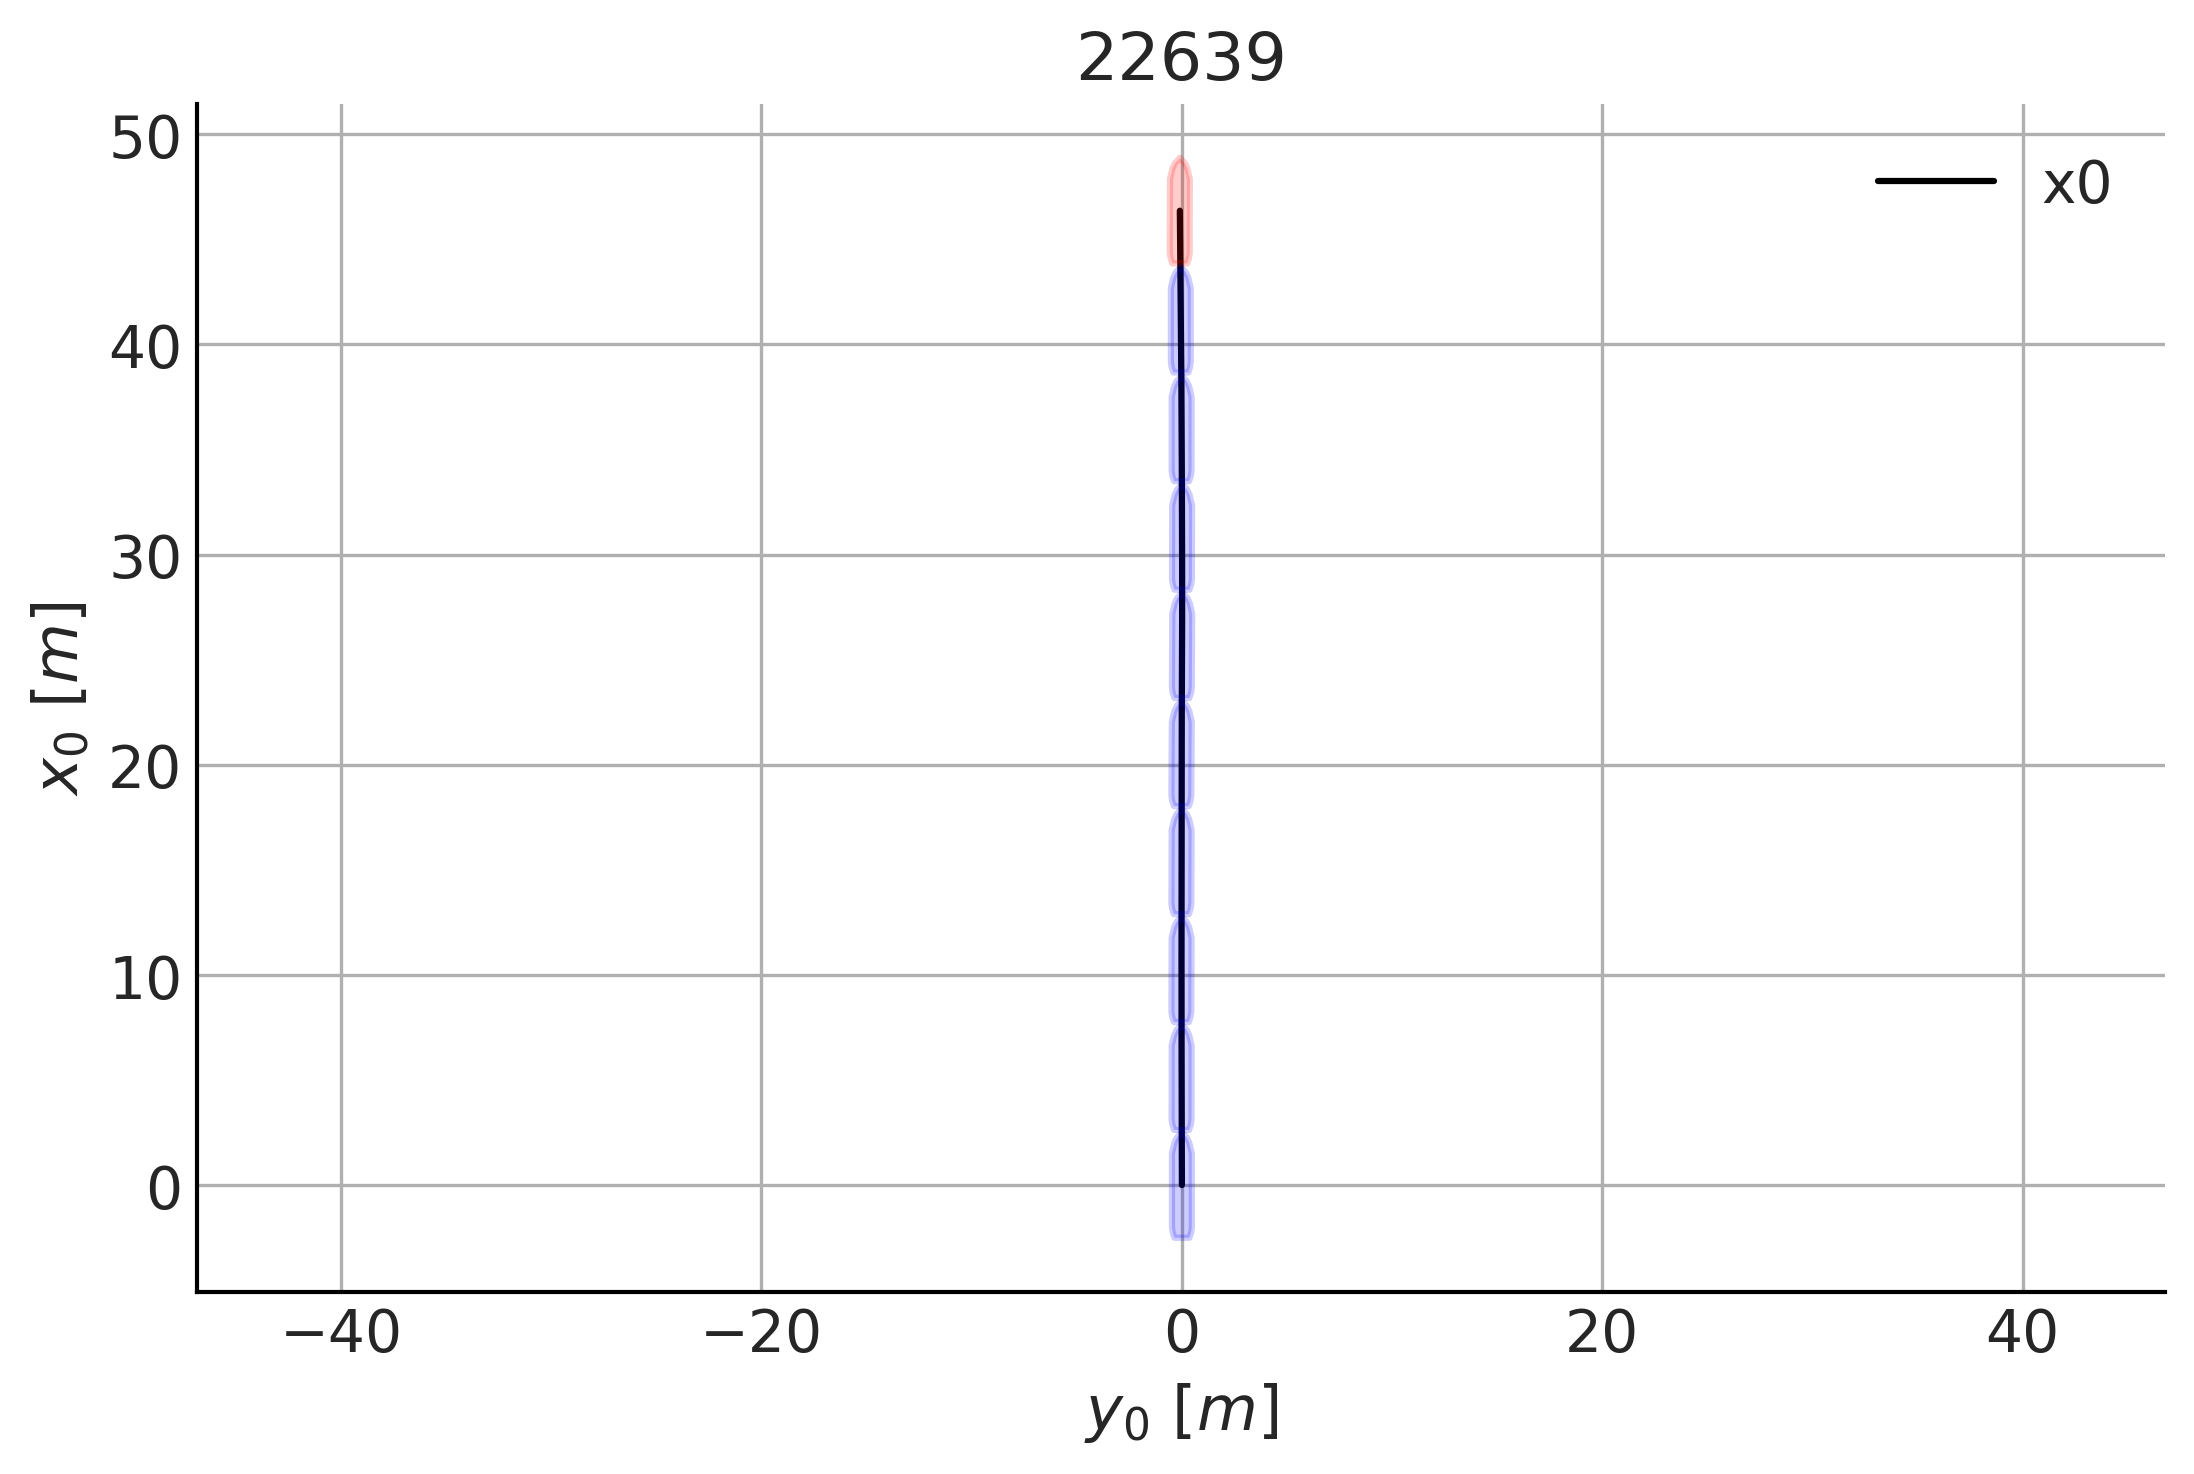

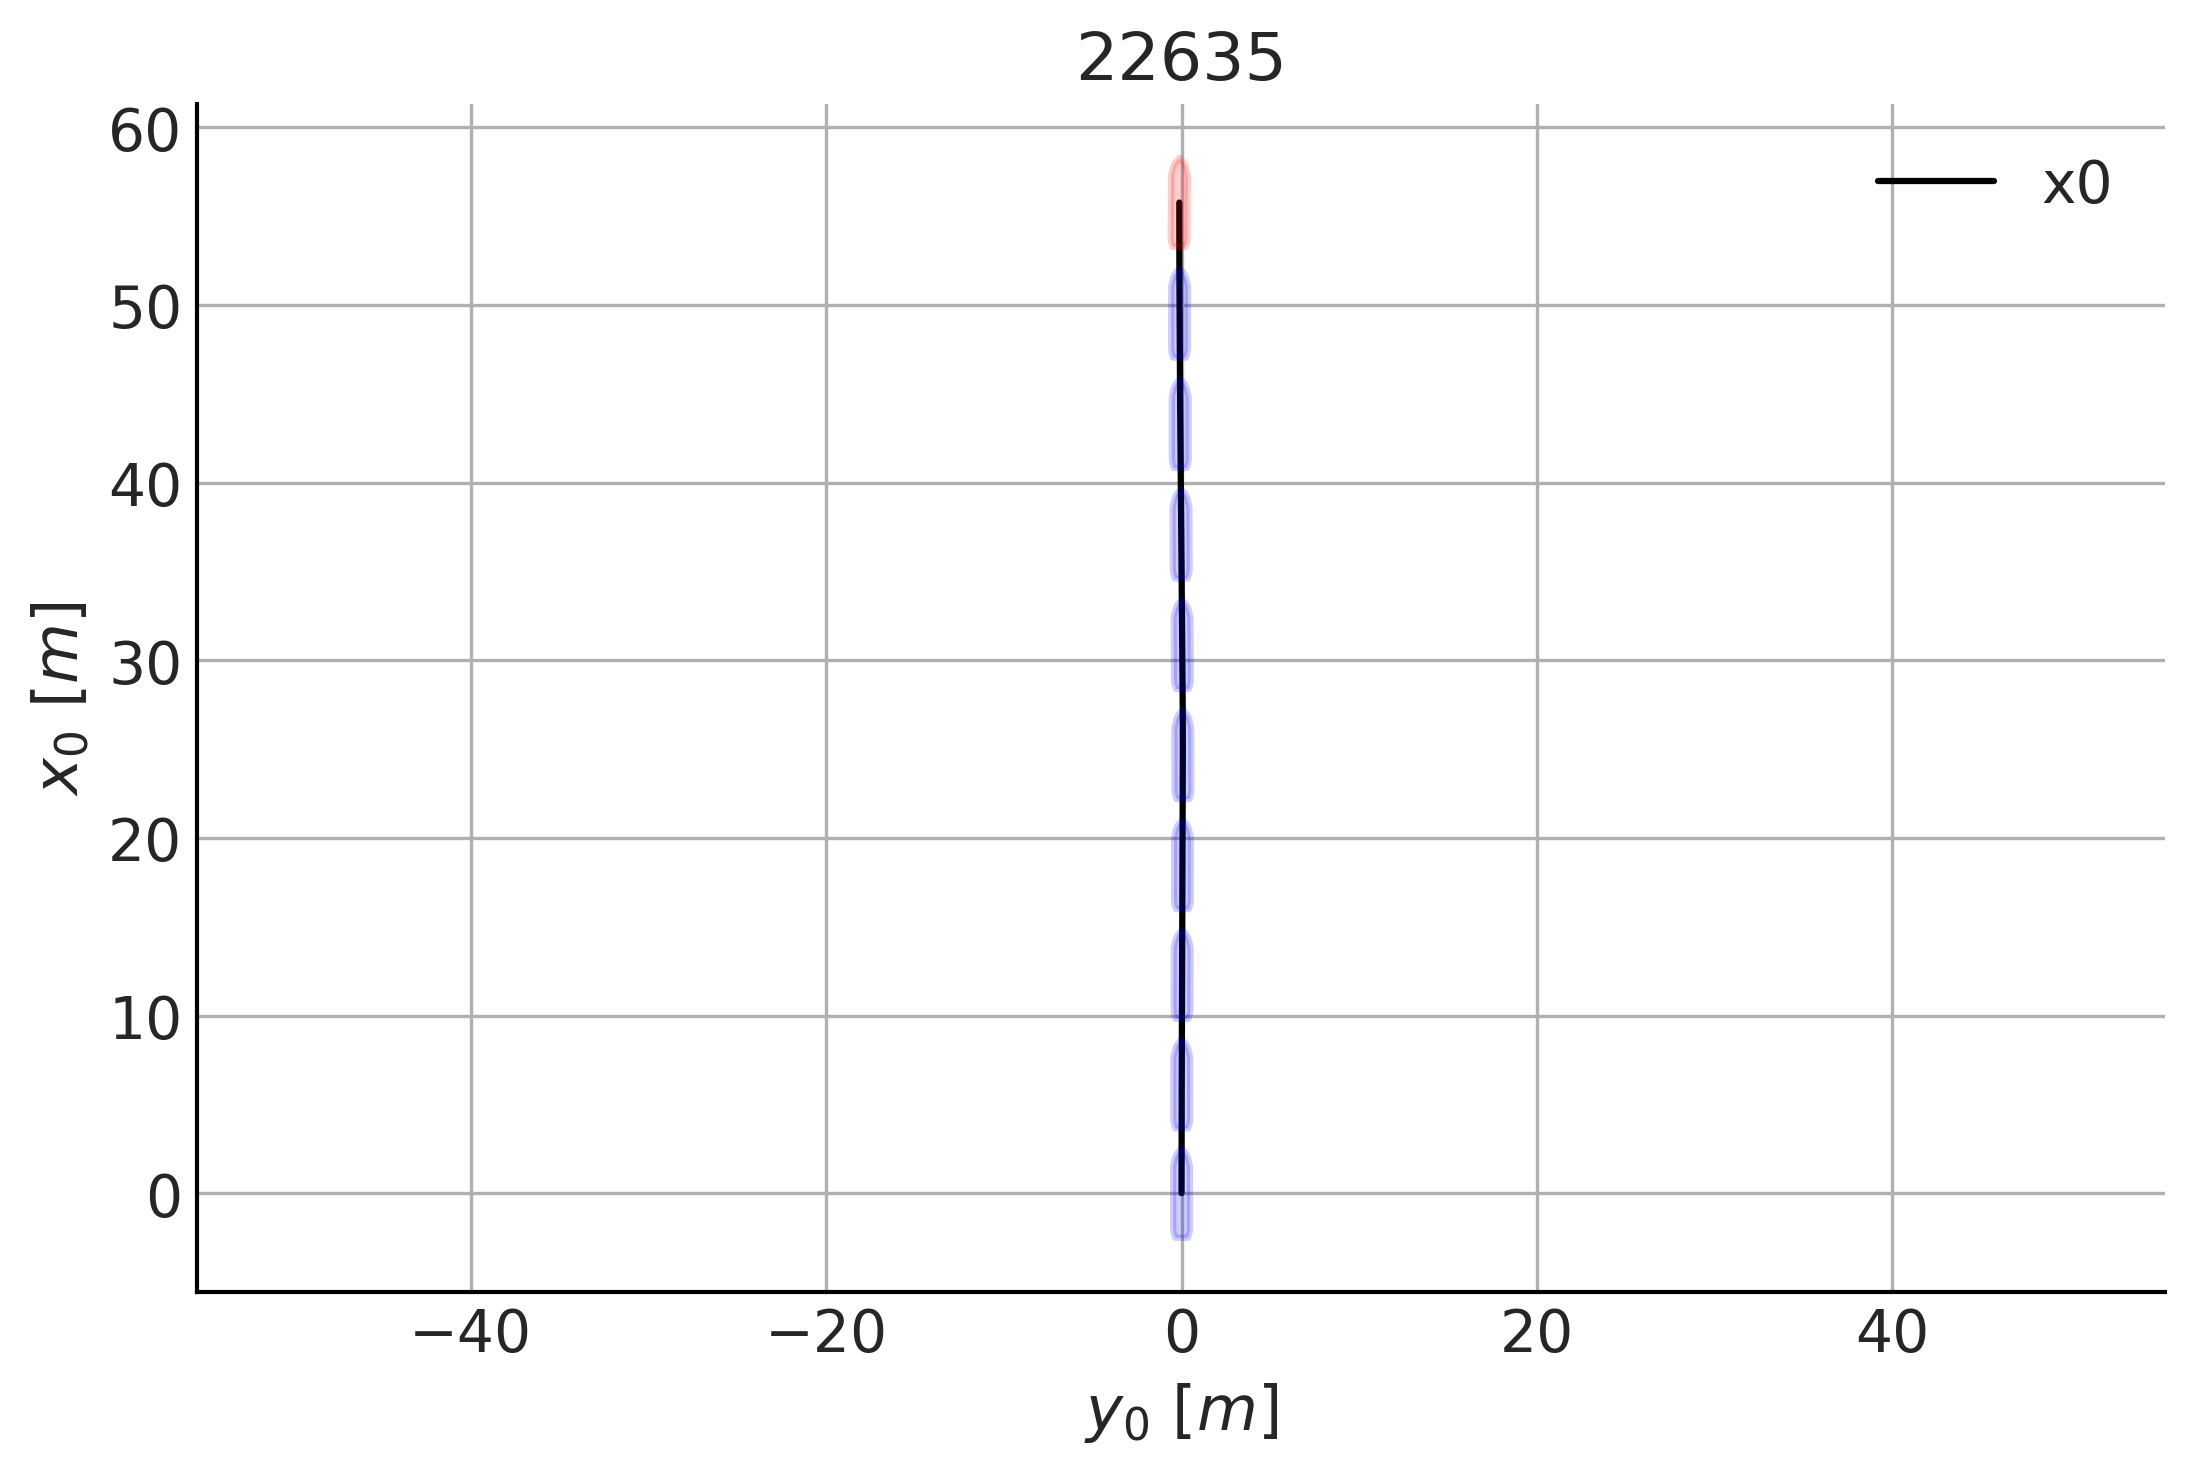

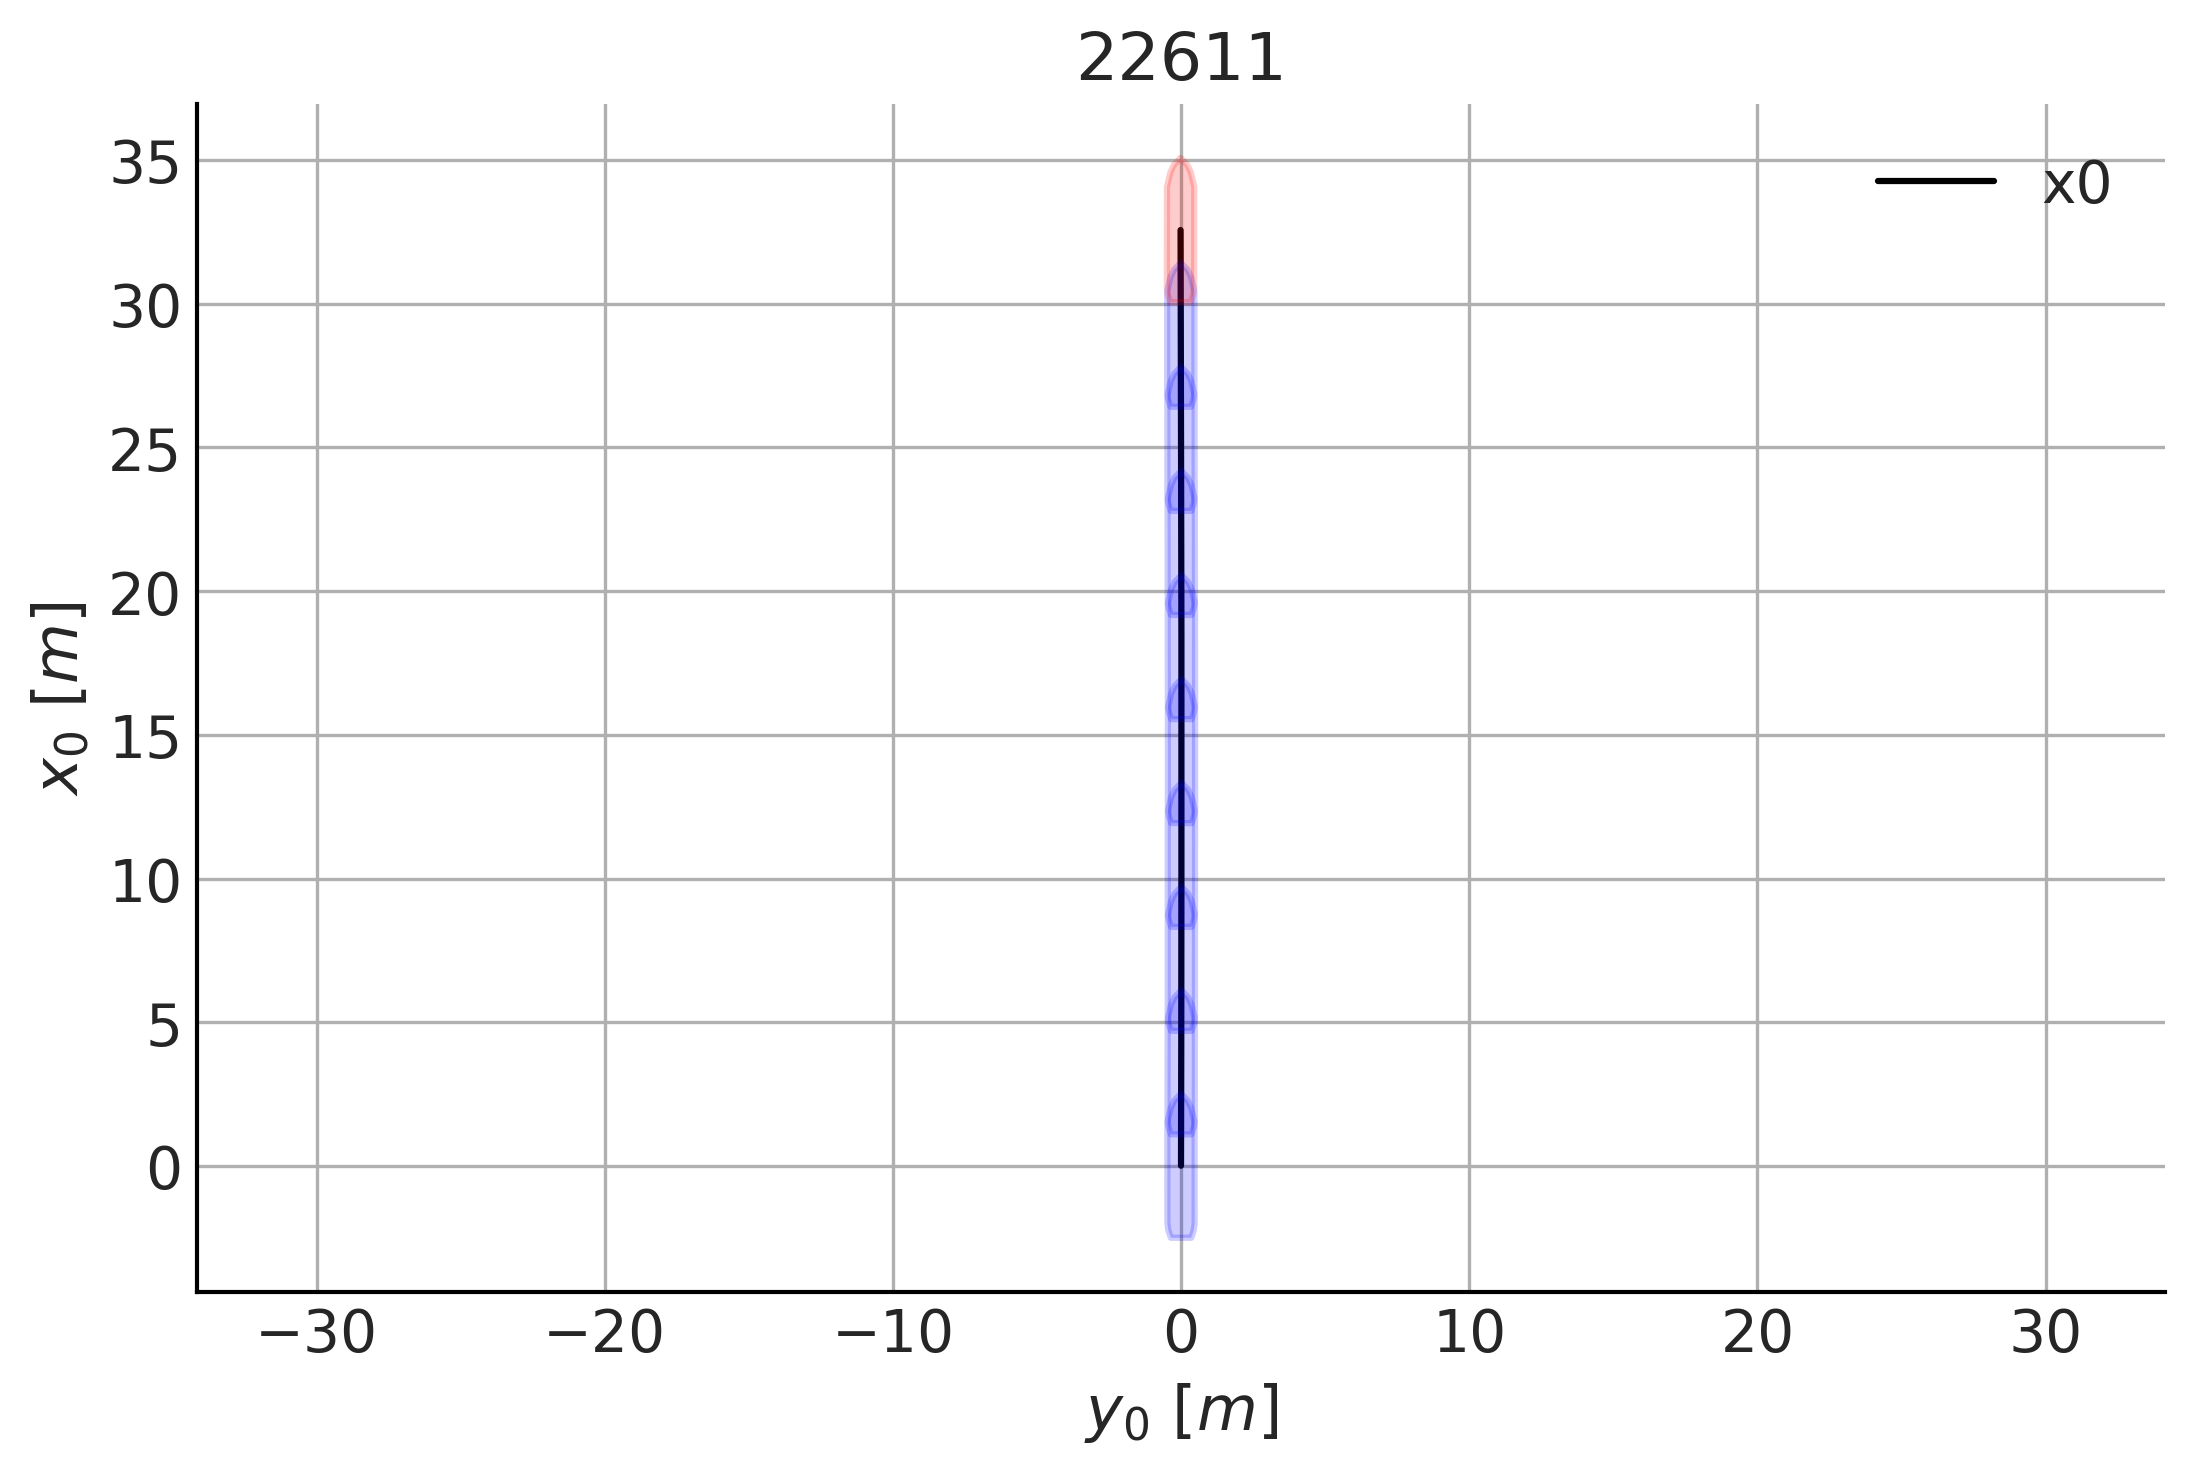

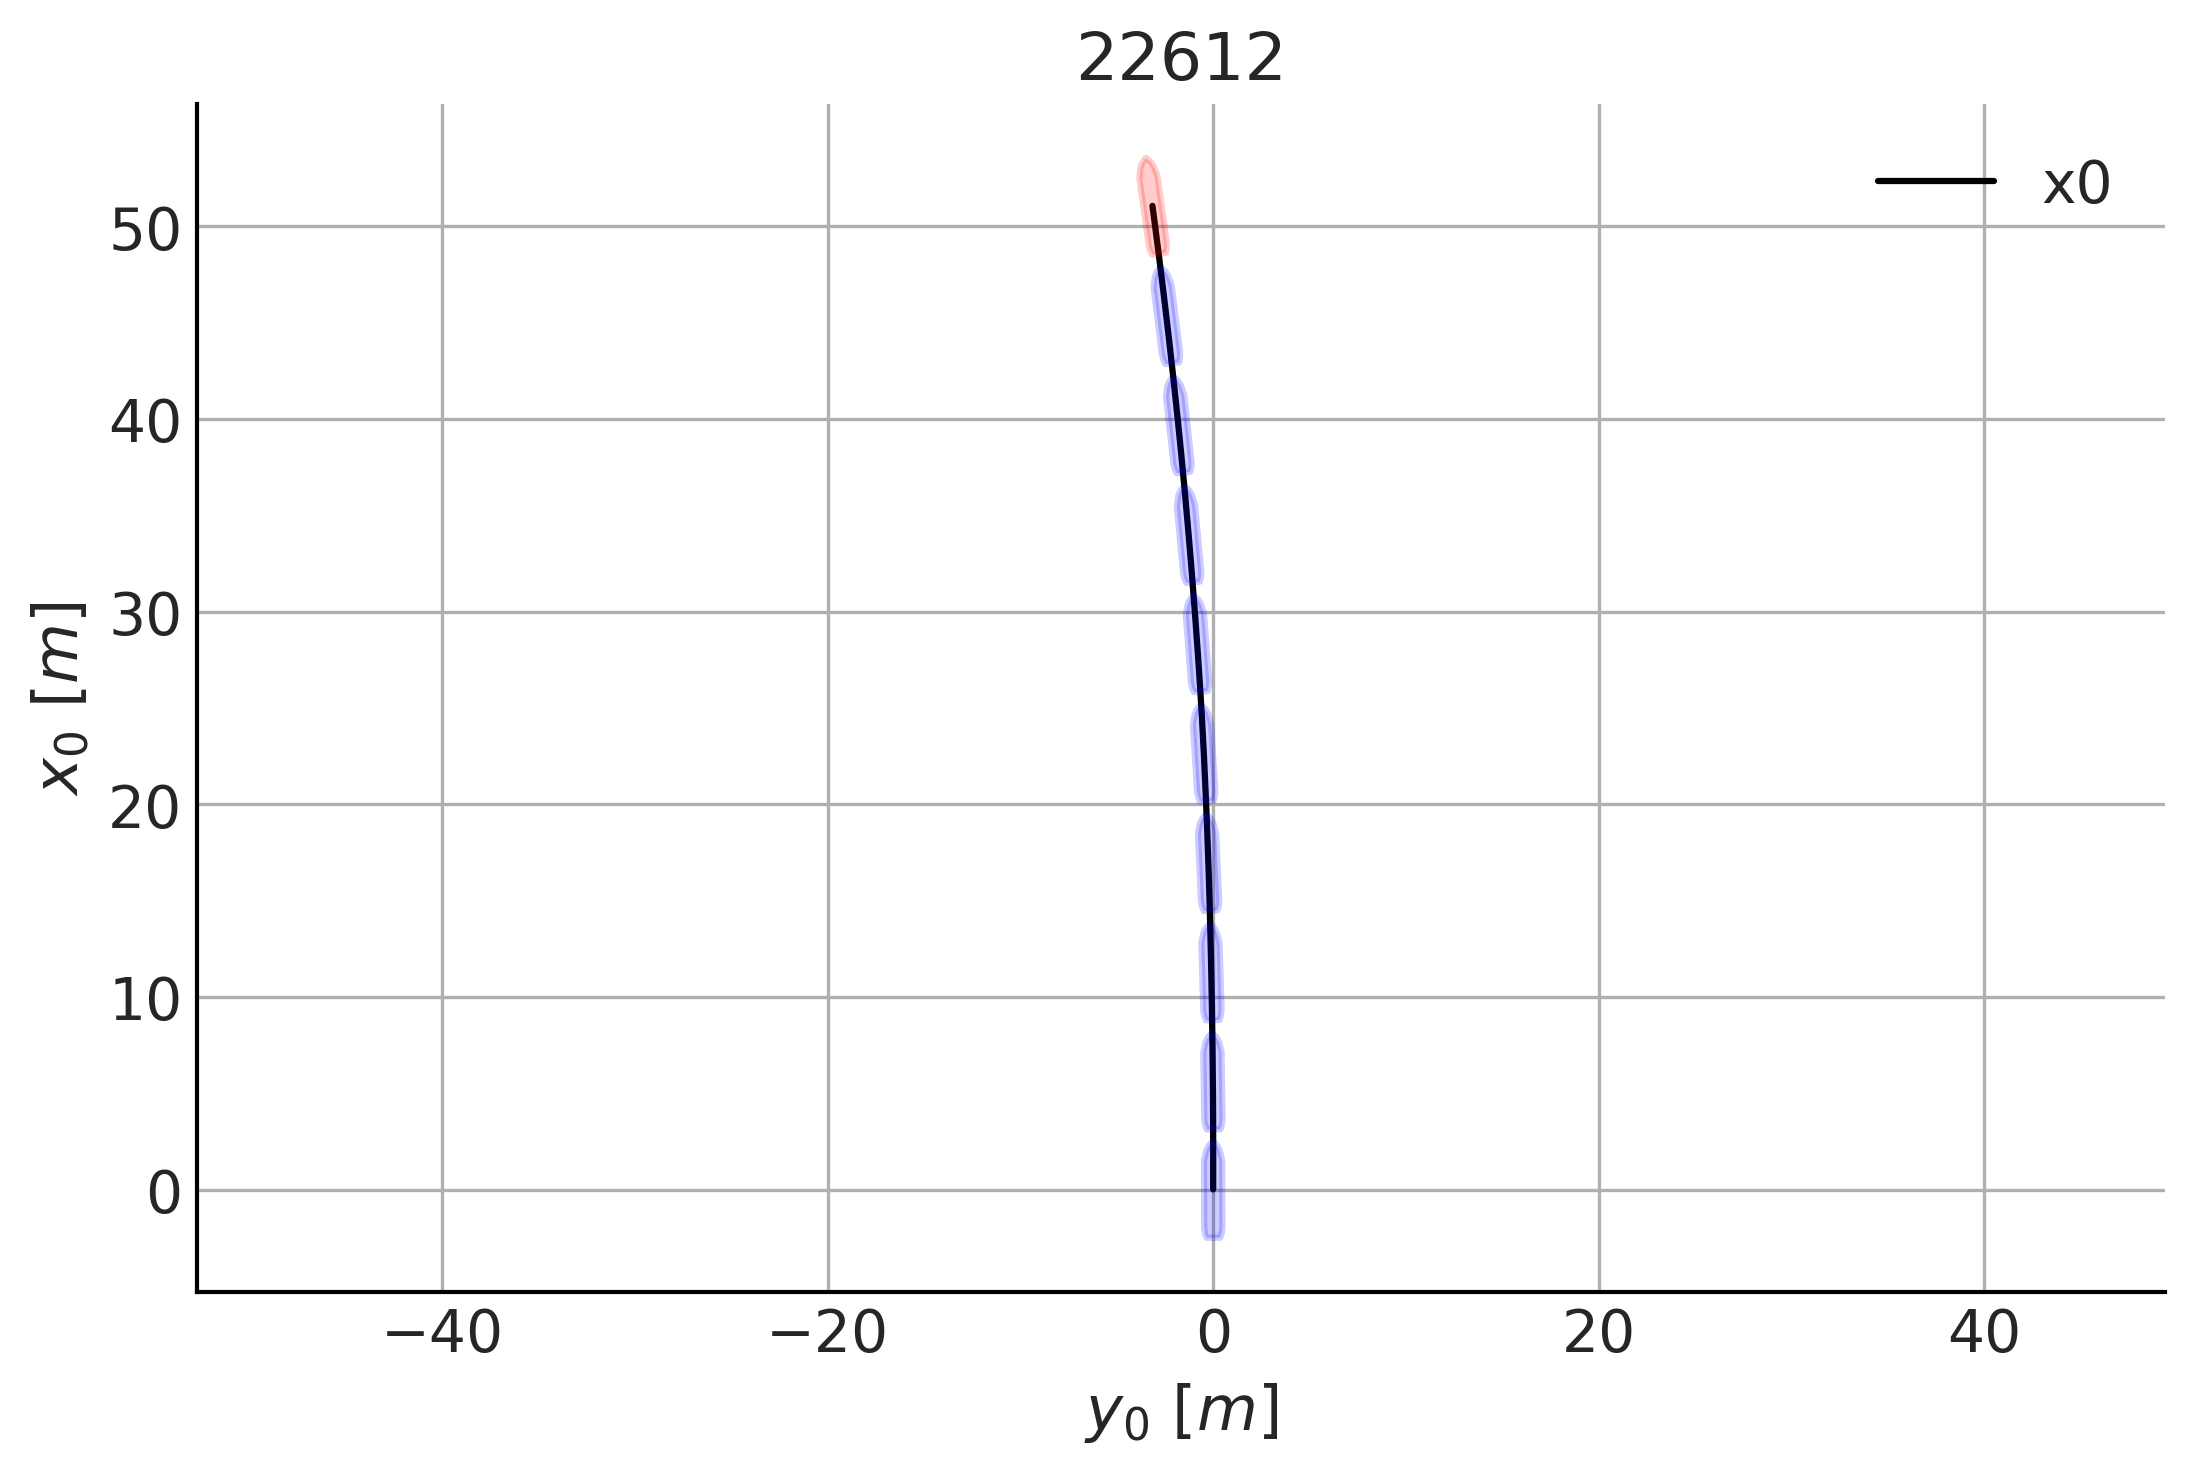

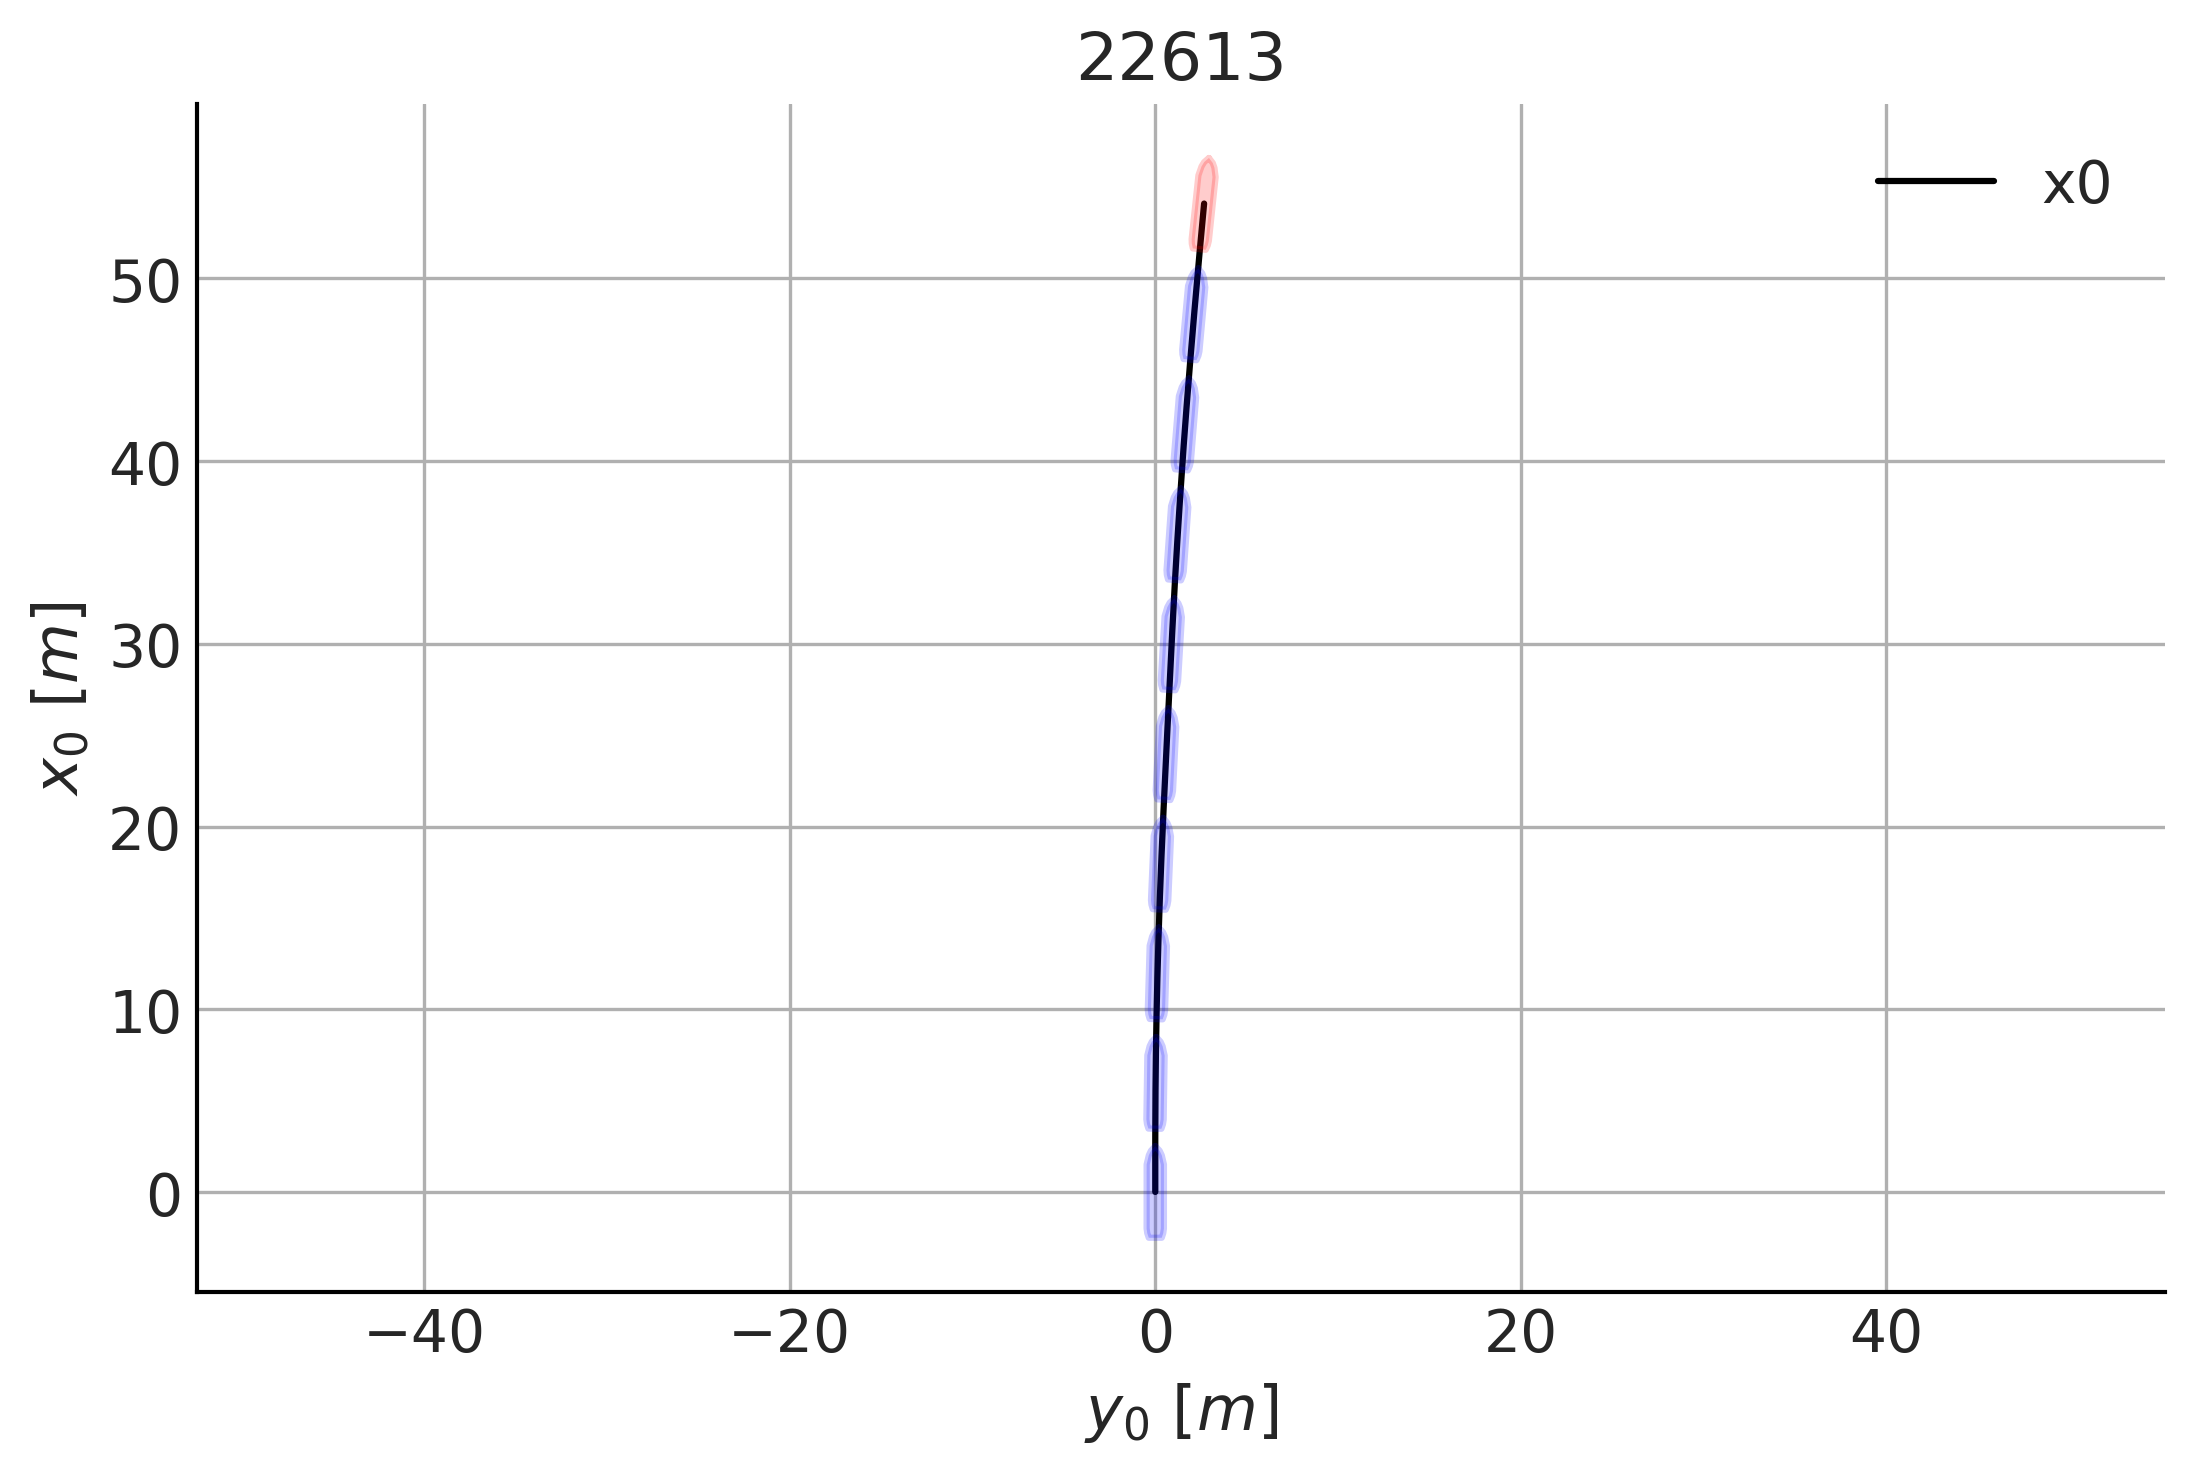

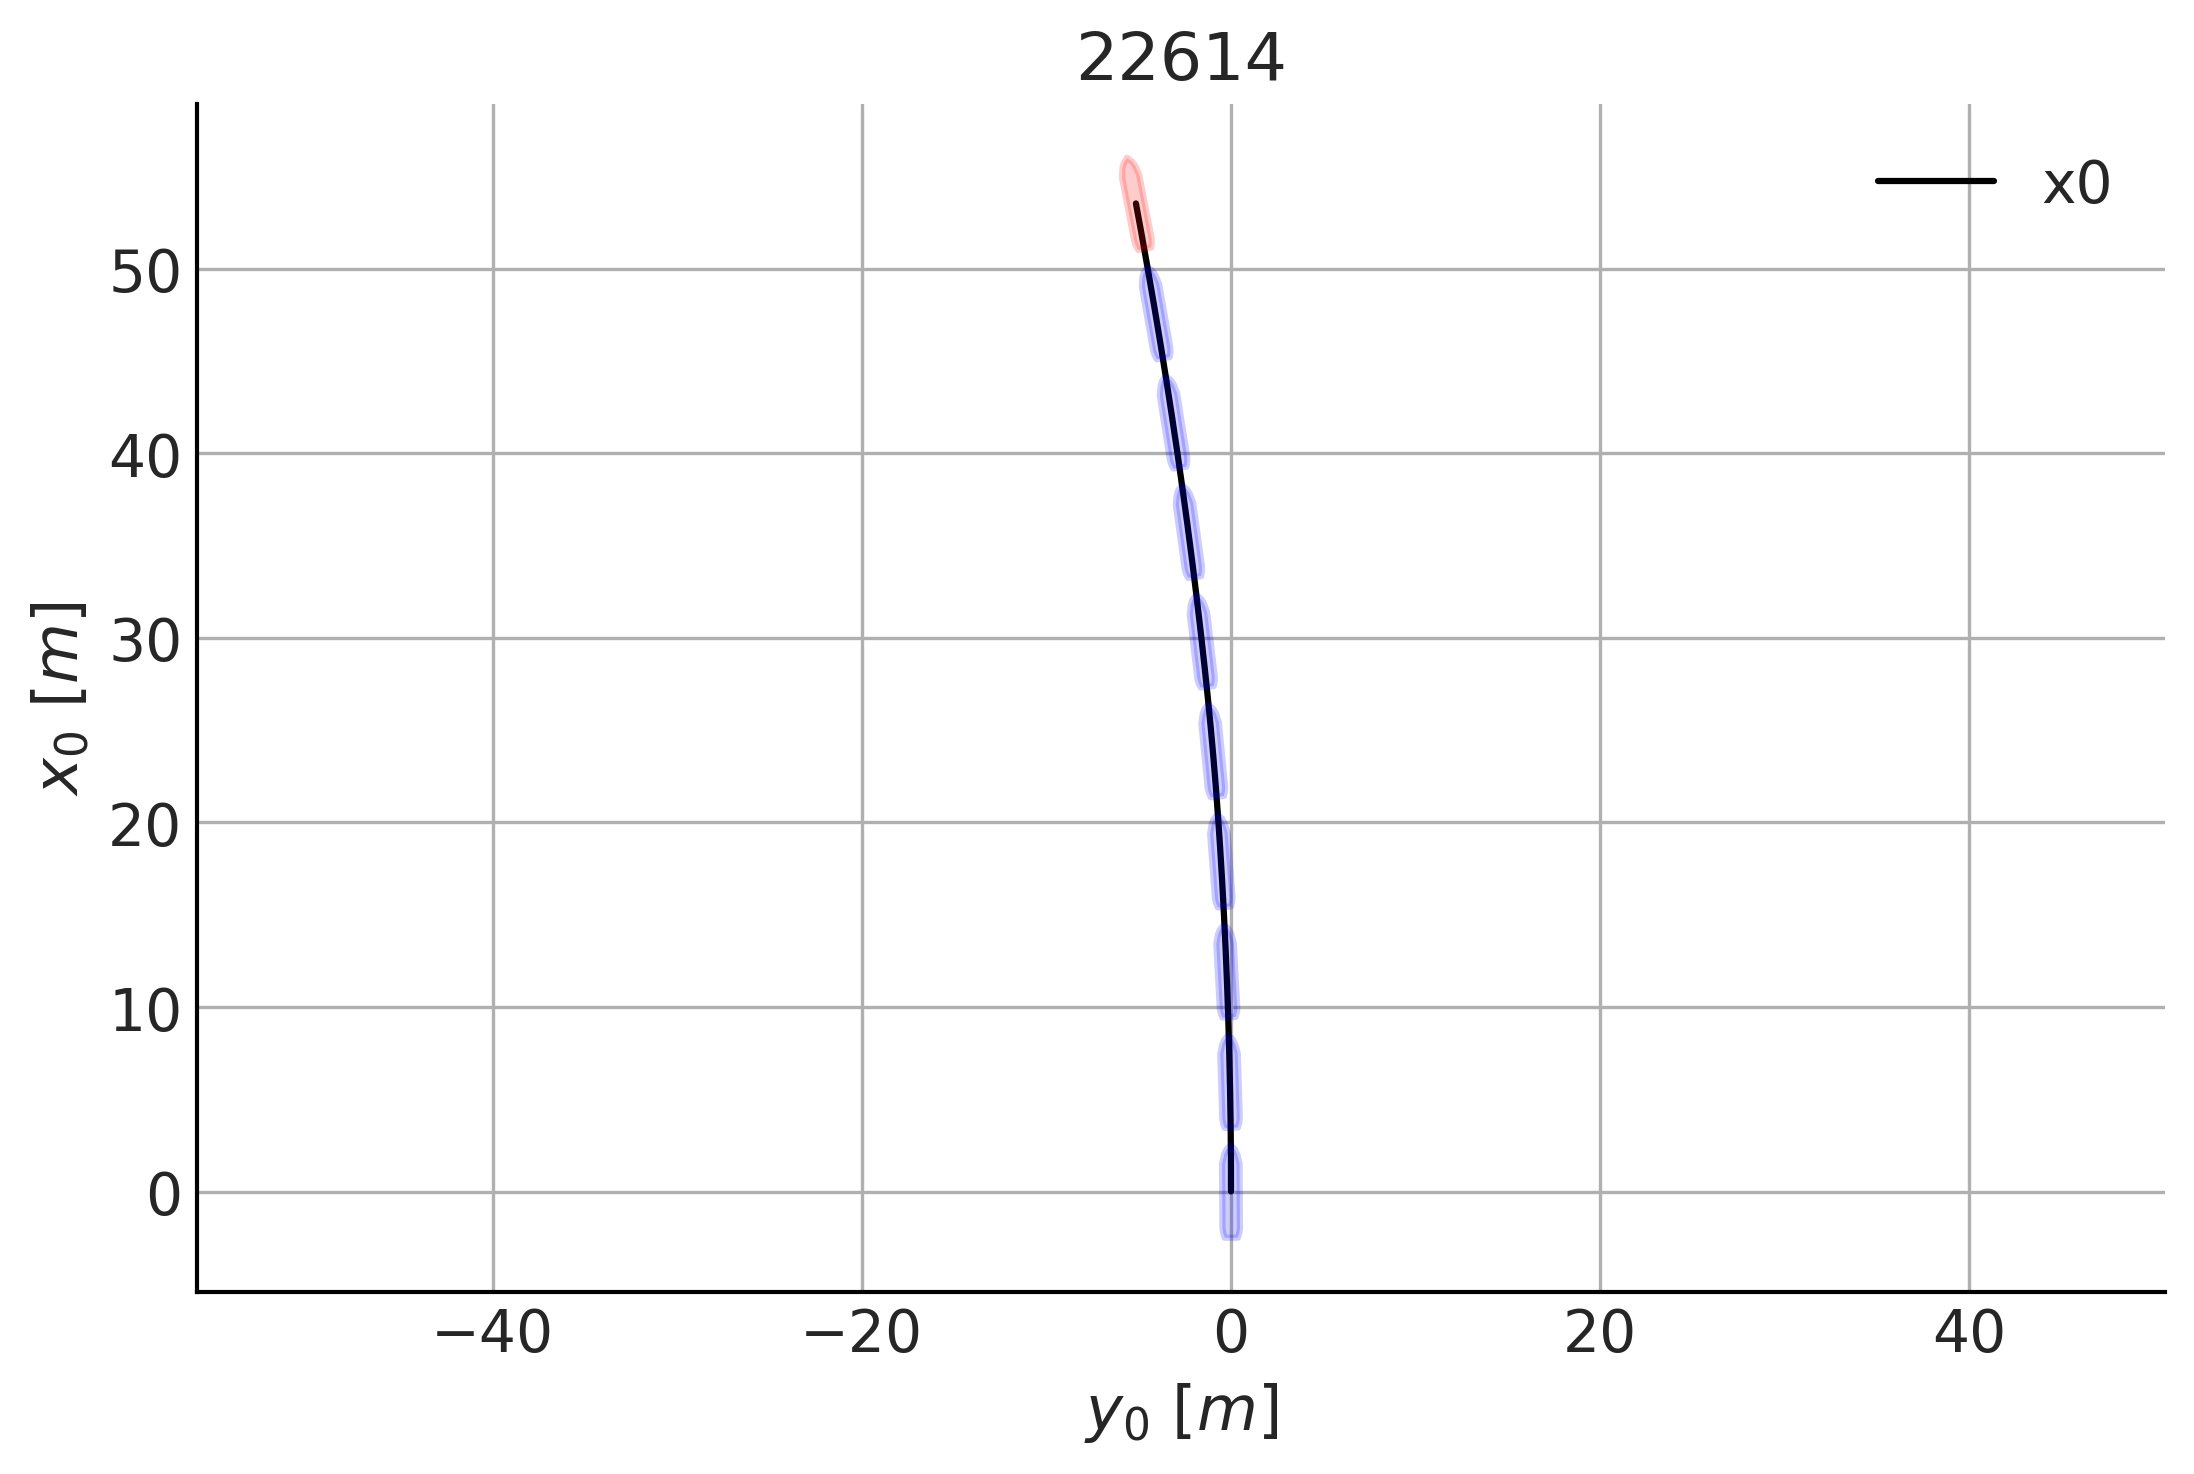

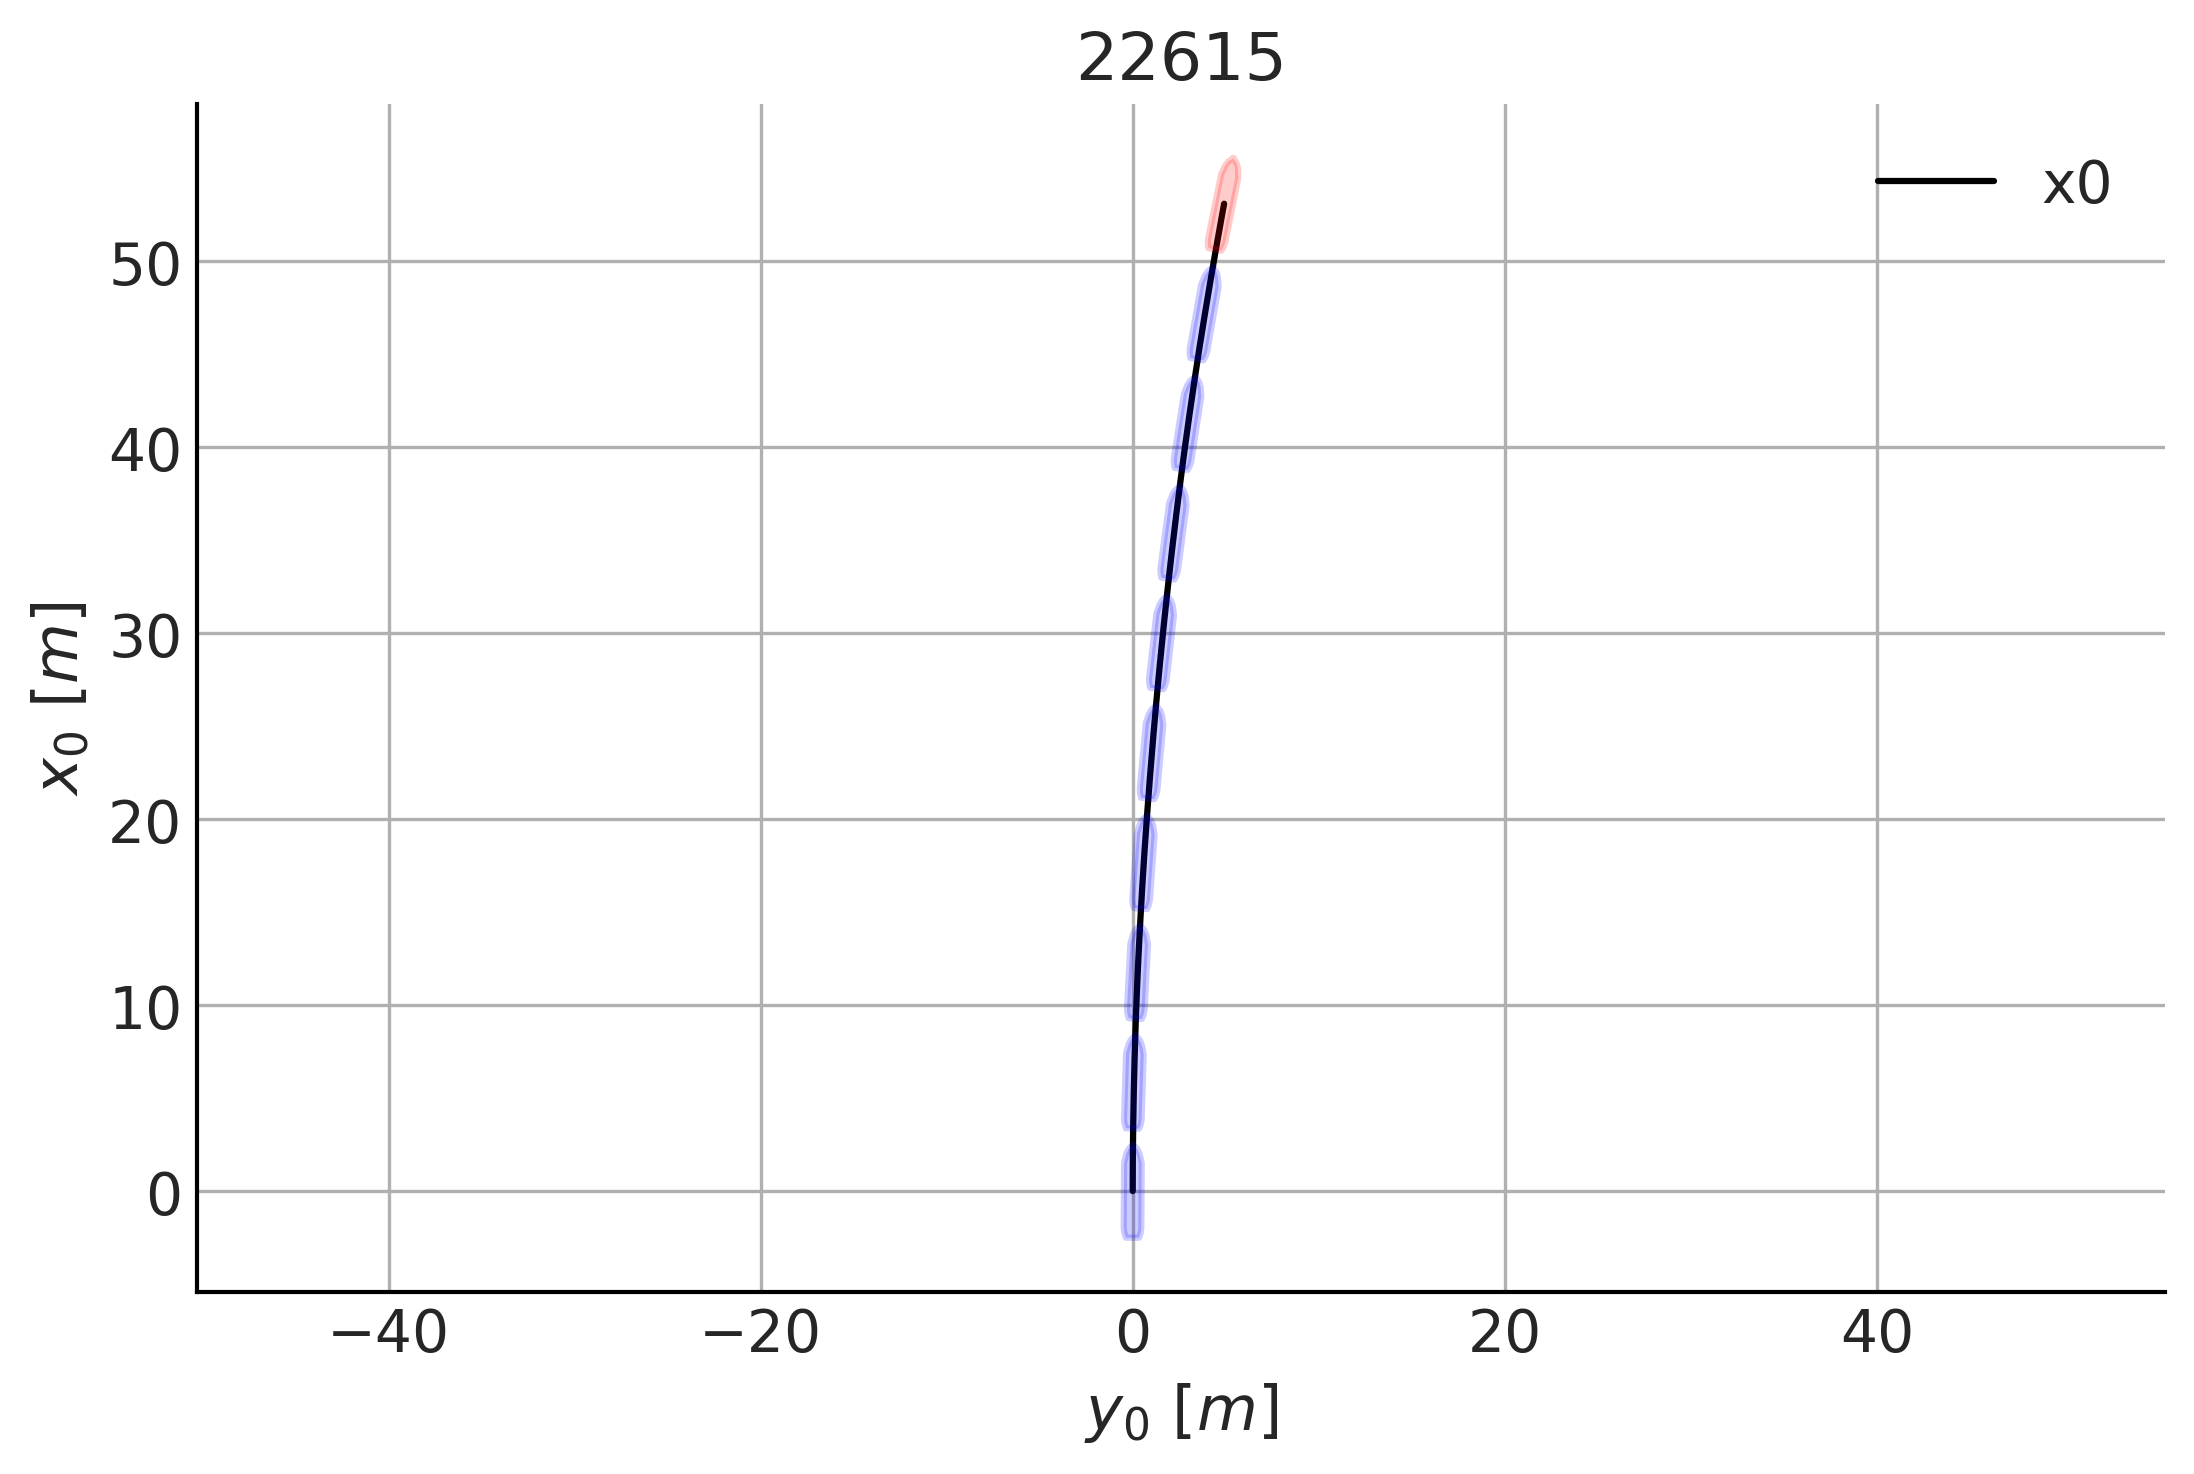

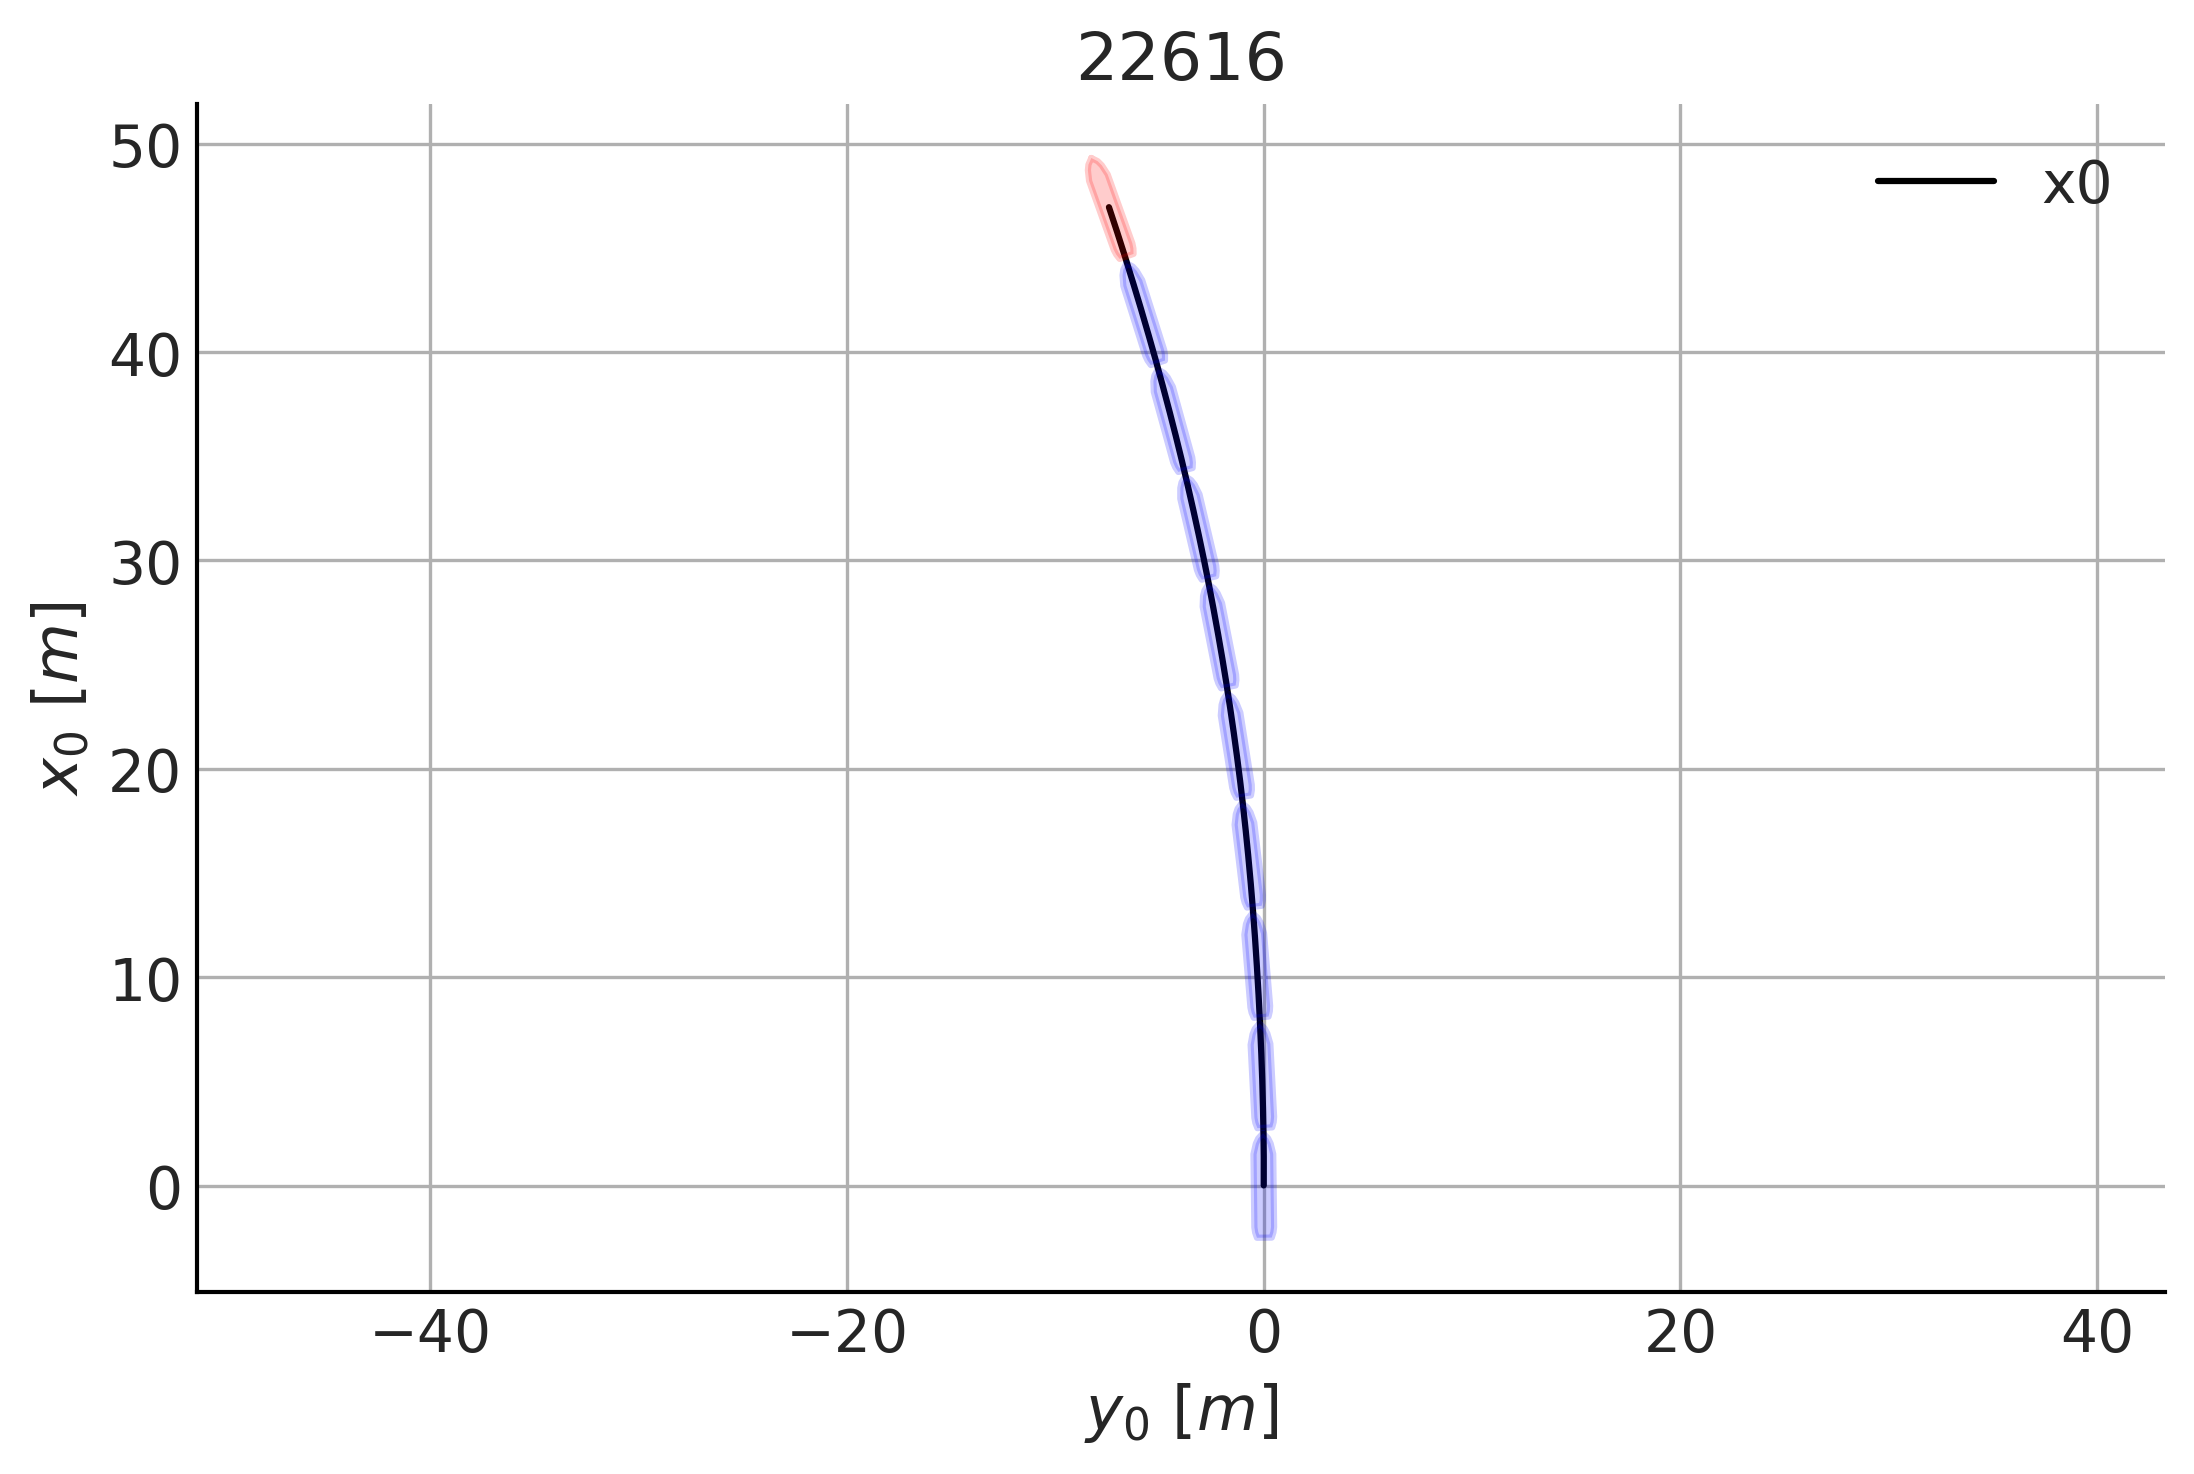

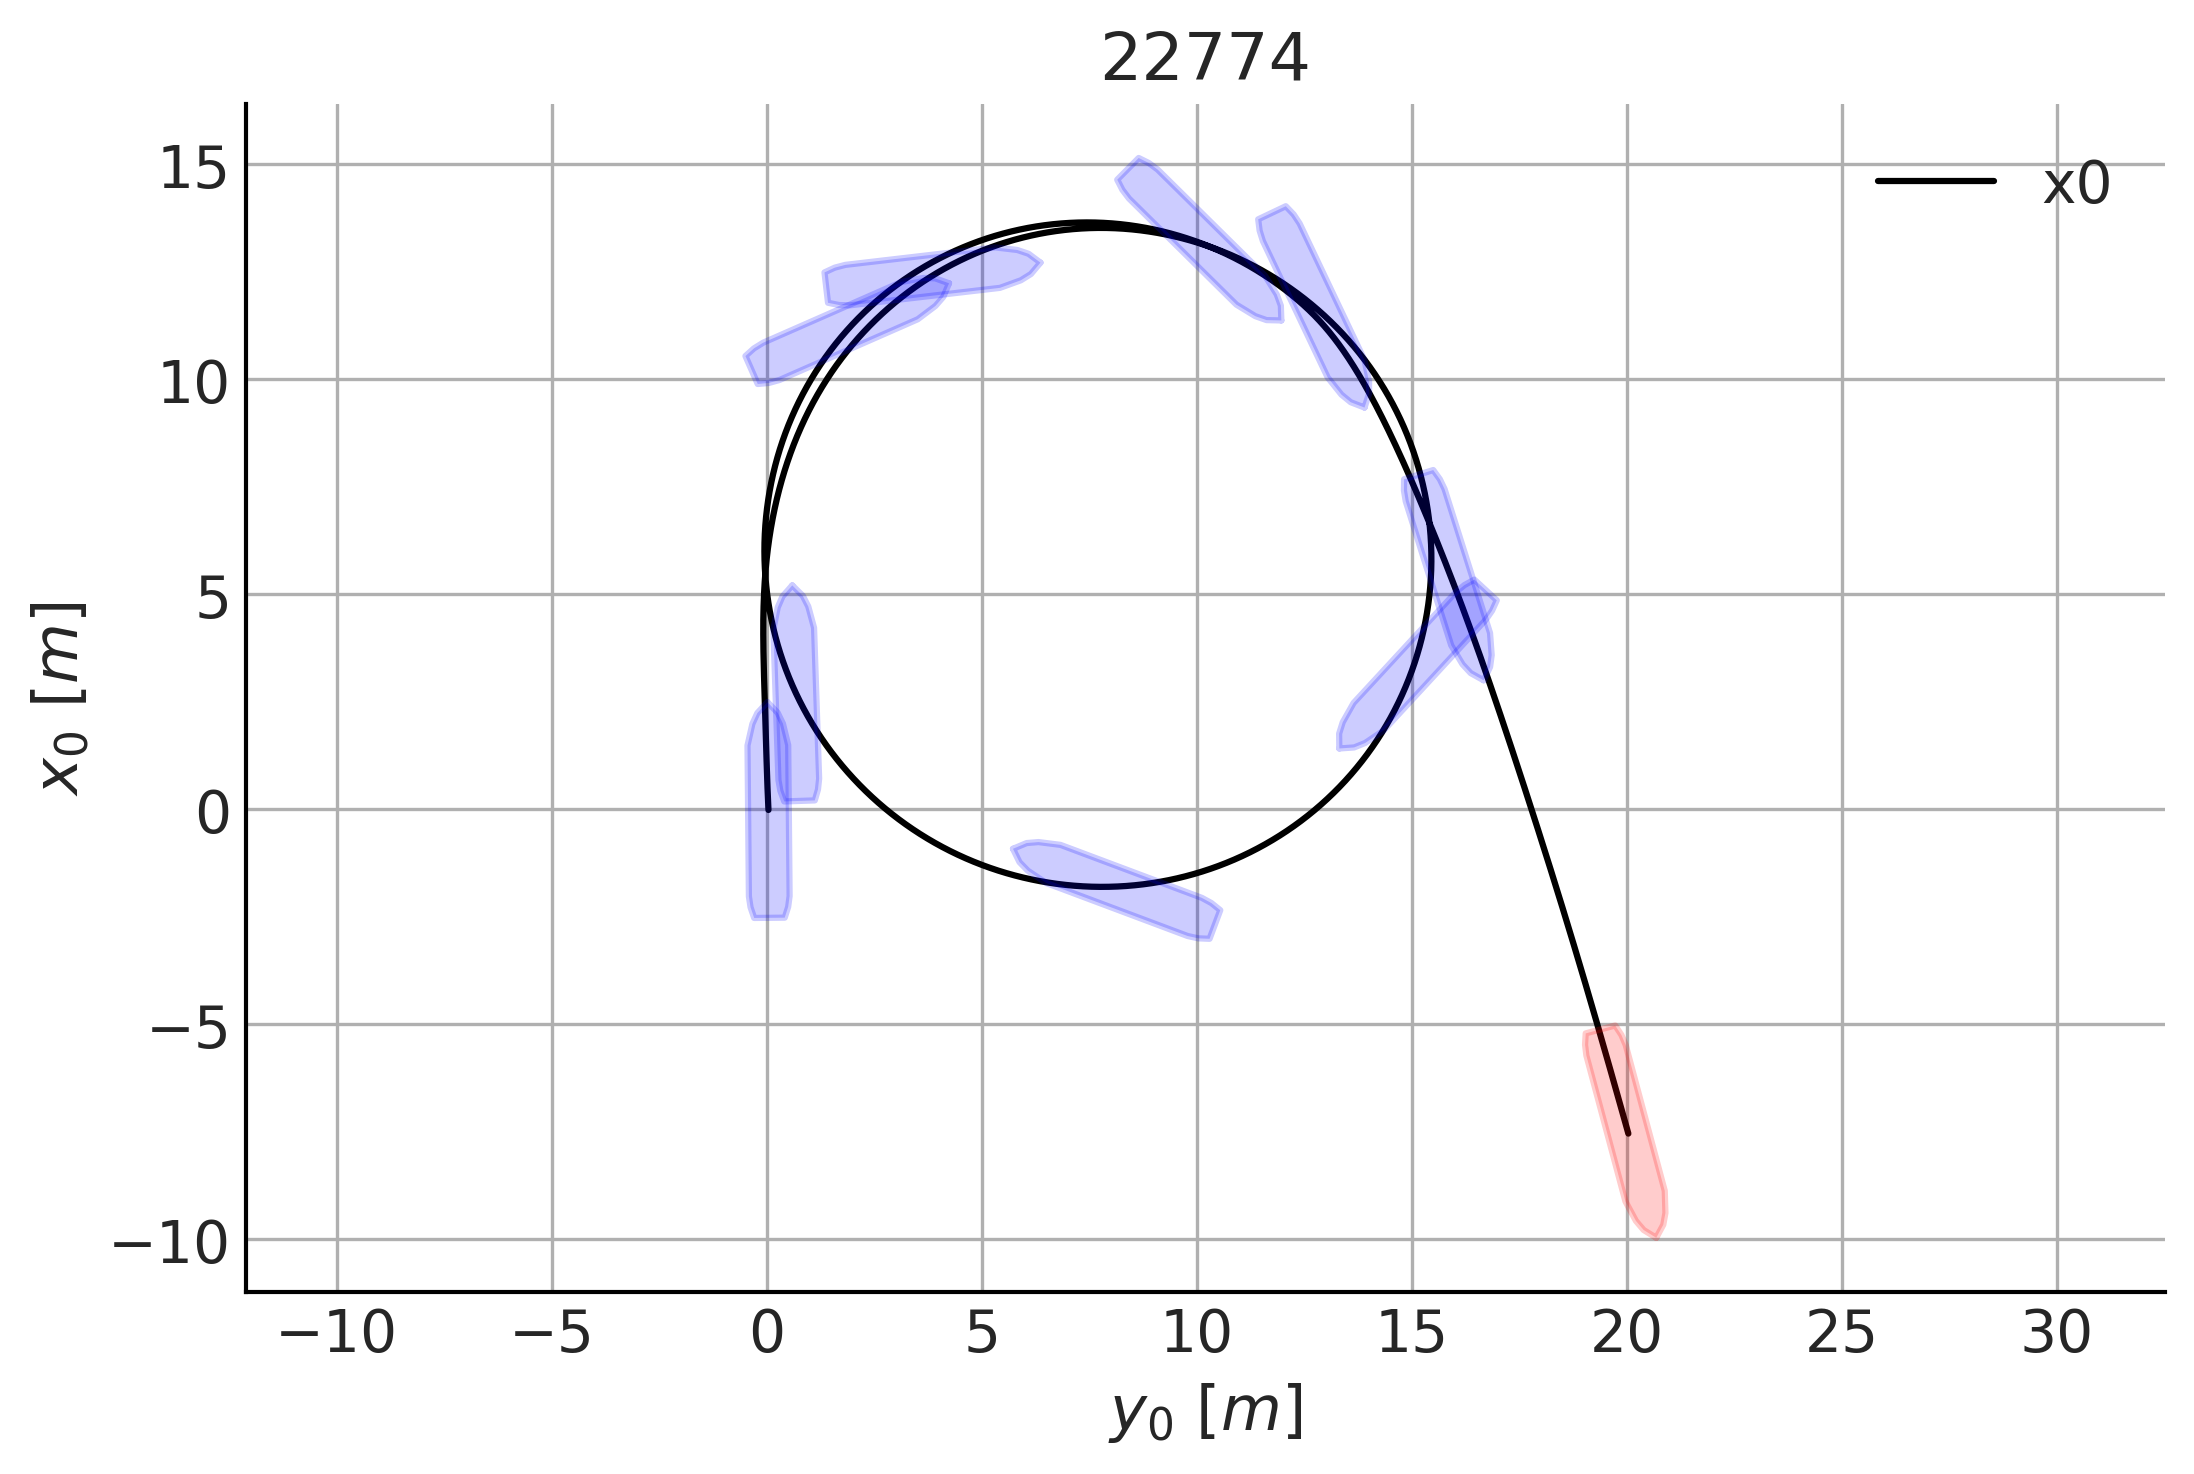

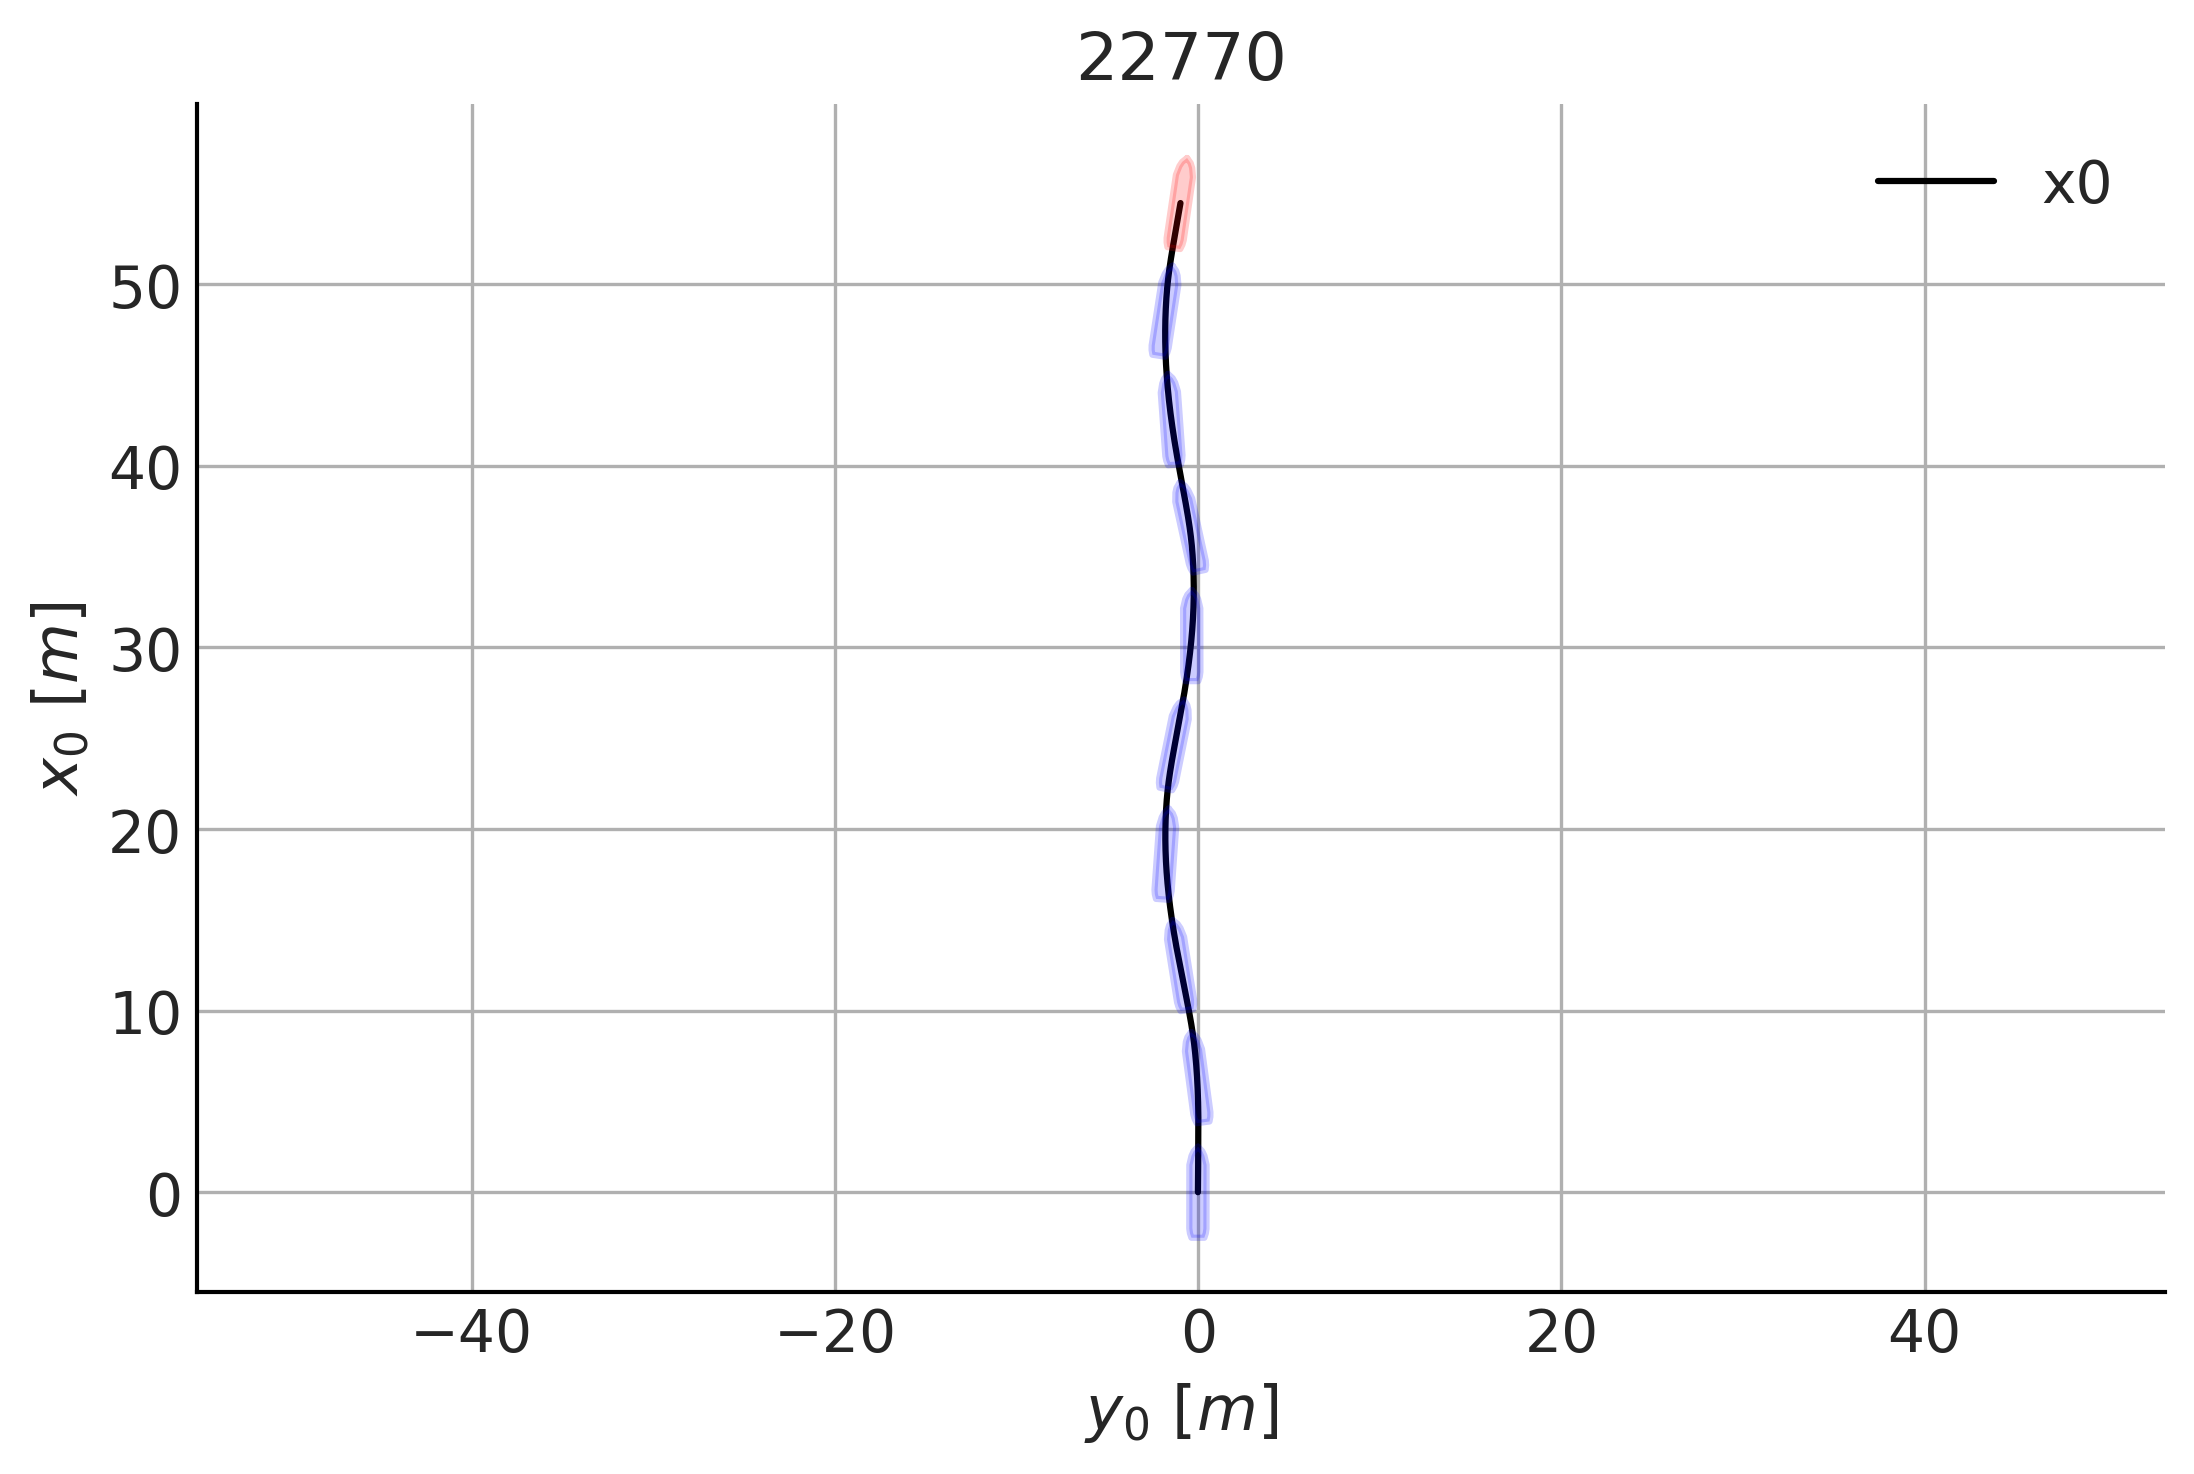

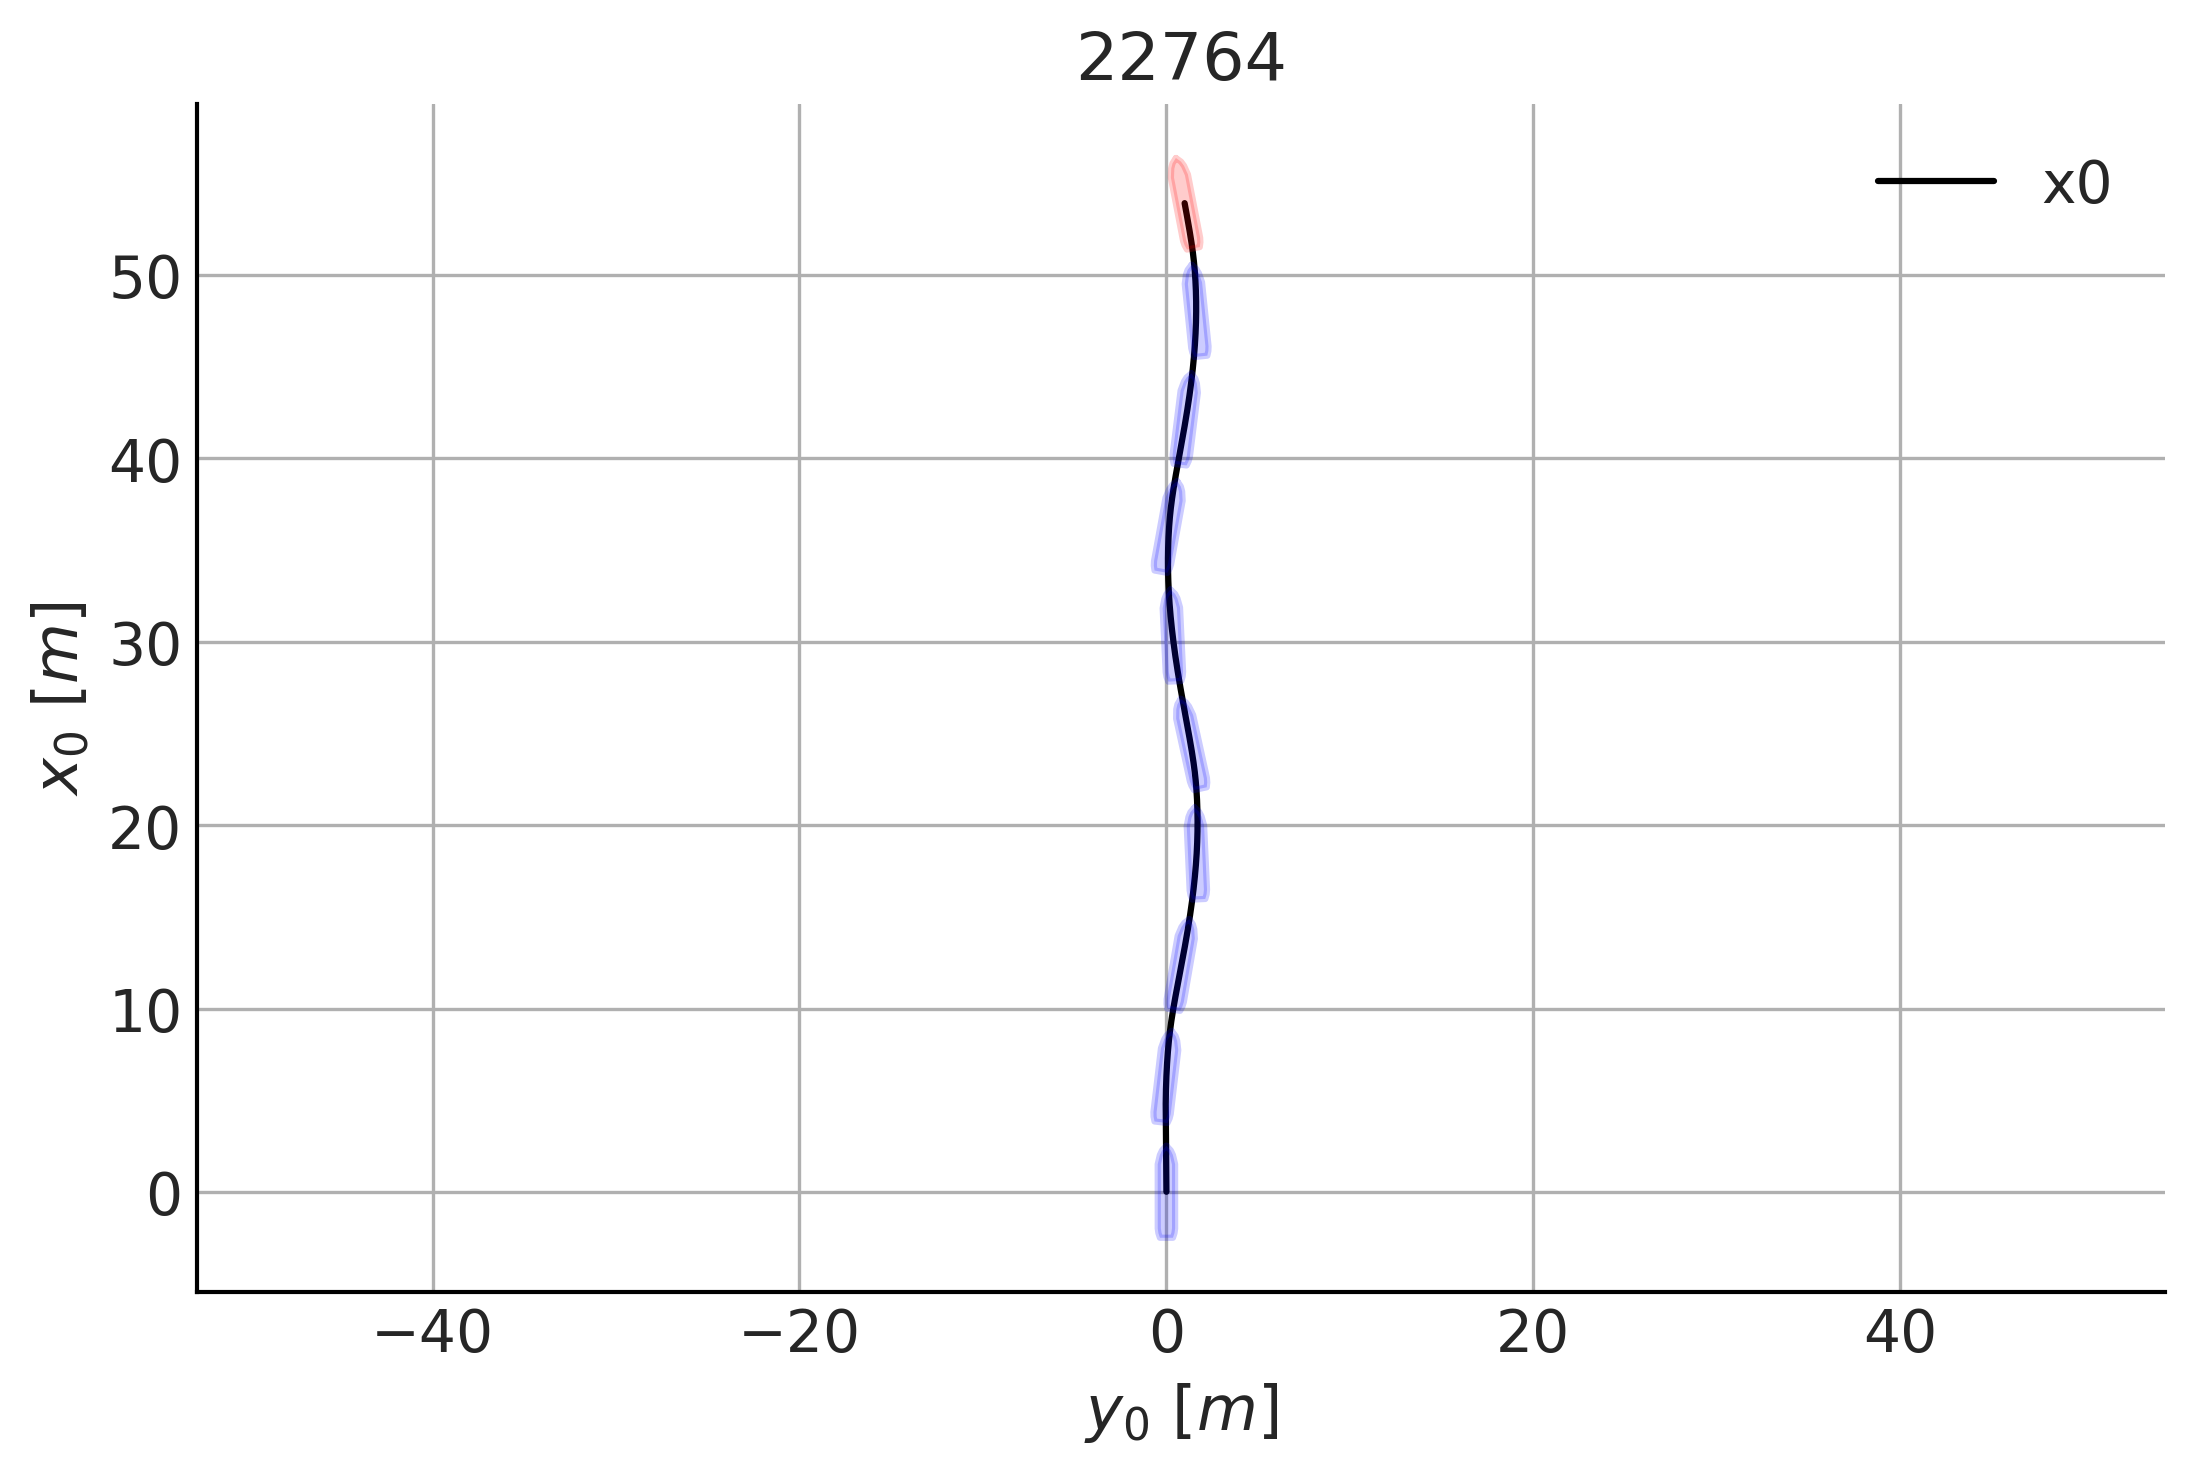

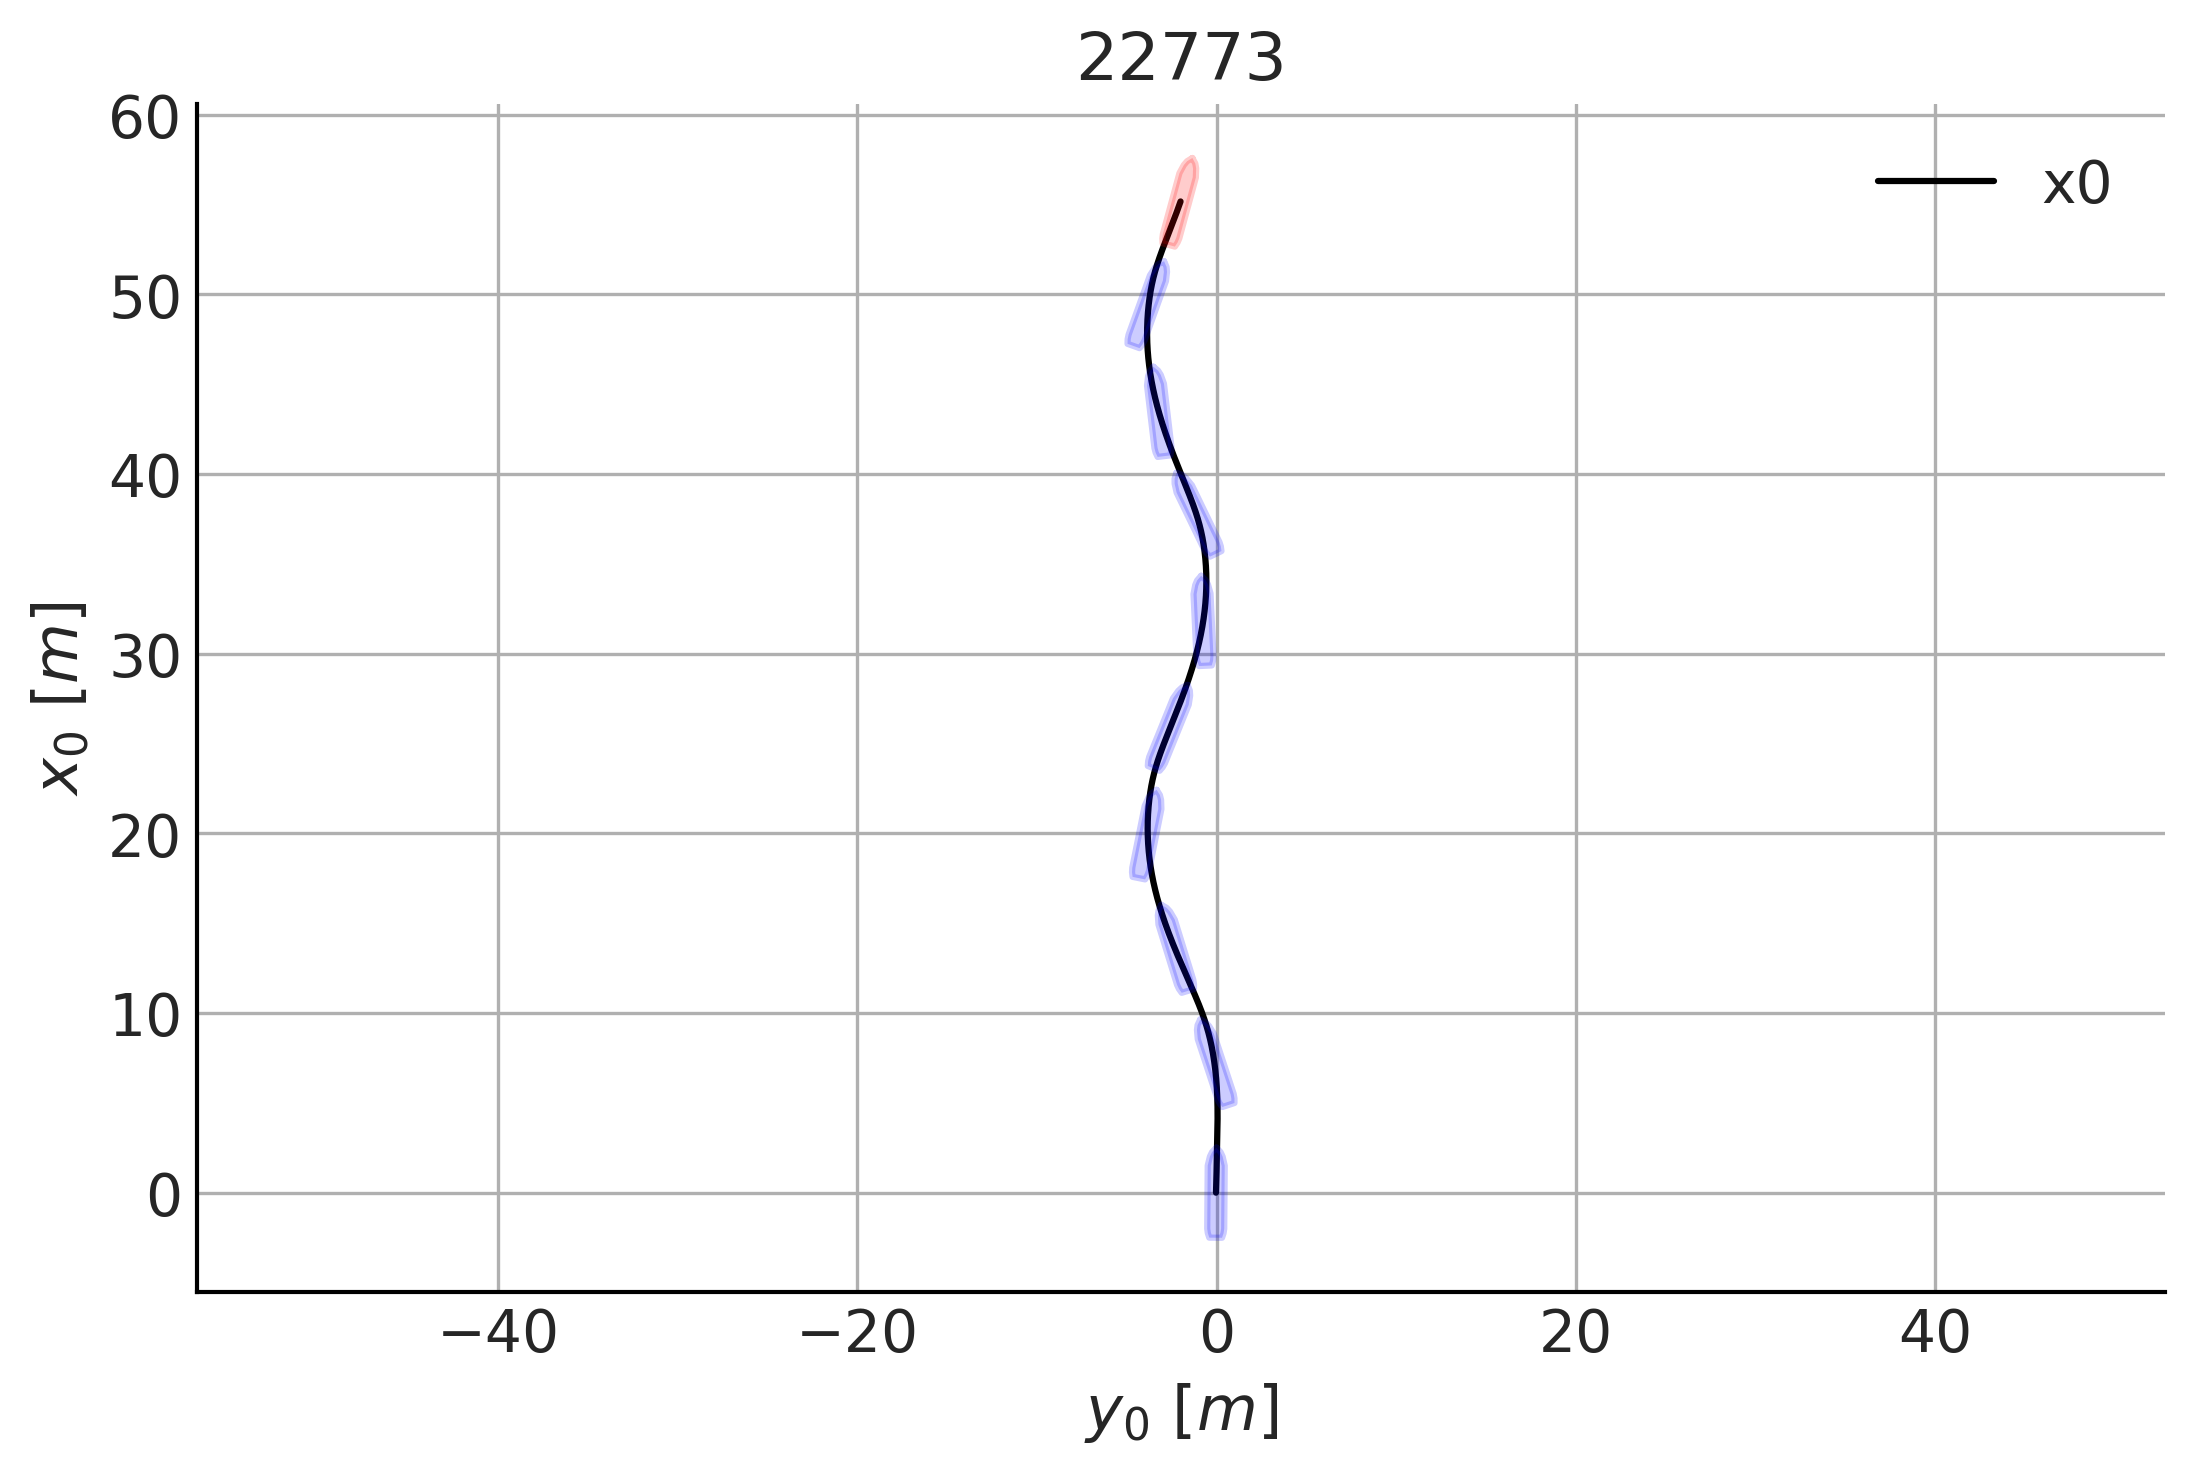

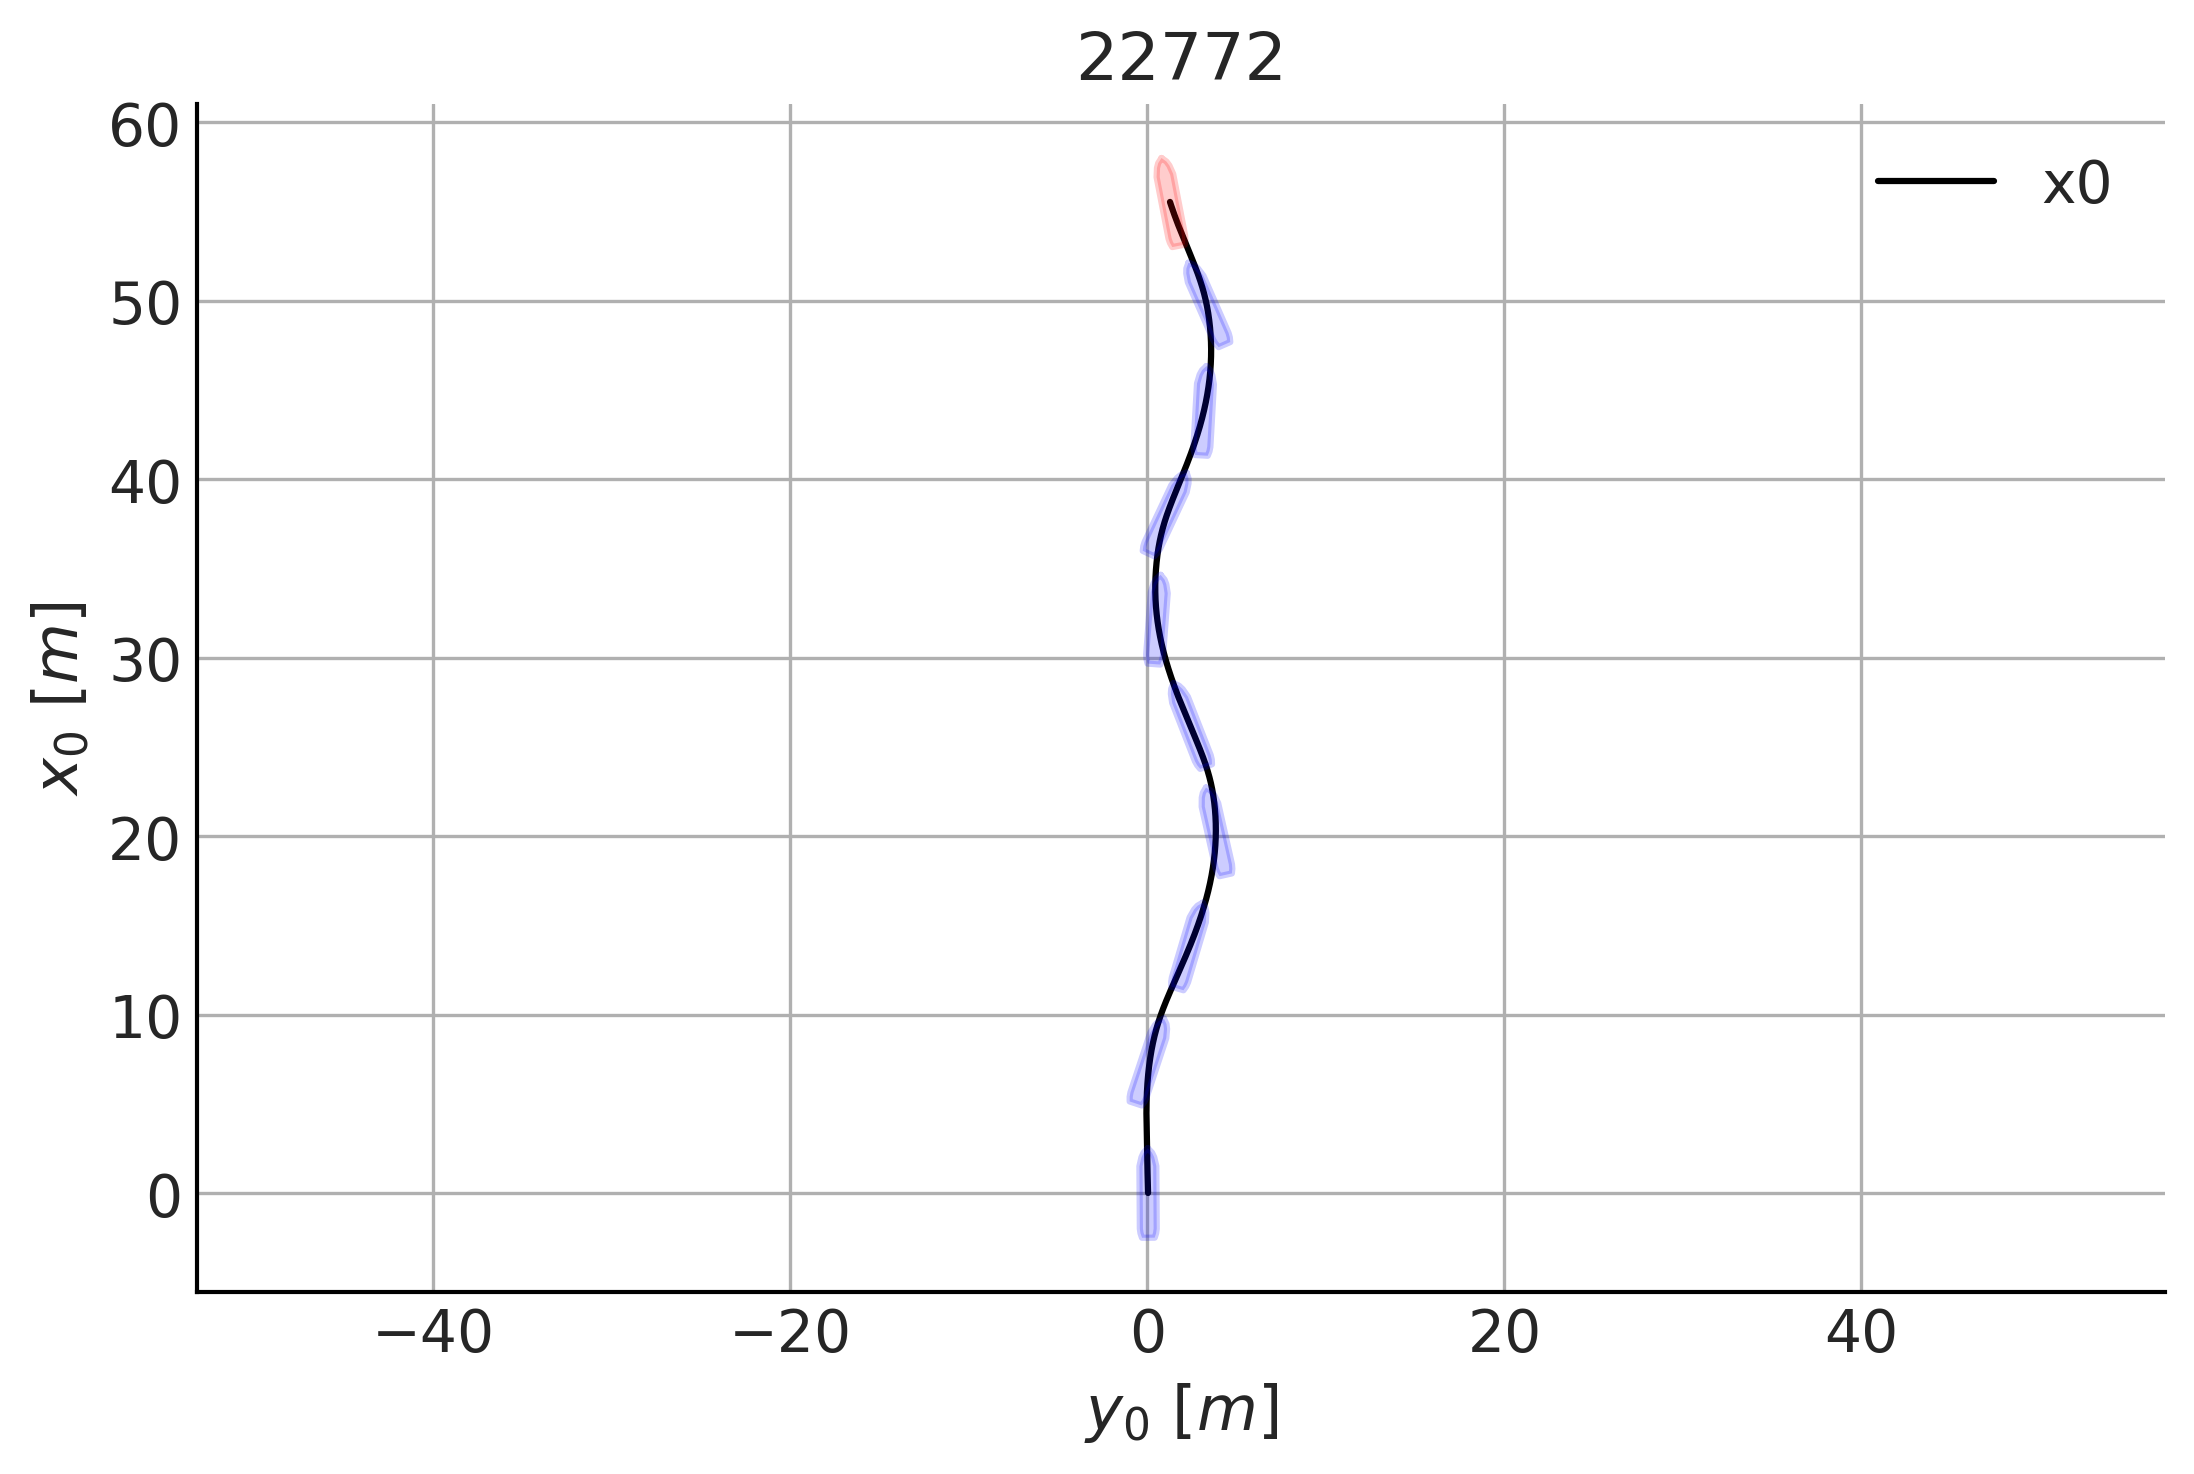

In [103]:
for id, row in time_series_meta_data_select.iterrows():
    
    data = time_series[f"wpcc.updated.{id}.ek_smooth"]()
    ax = track_plot(data, lpp=shipdata['L'], beam=shipdata['B'], N=10)
    ax.set_title(id)
    